# Setup and Data Loading
Start by importing necessary libraries and loading the data

In [143]:
import pandas as pd
import numpy as np
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
#!pip install adjustText
from adjustText import adjust_text

# Set seed for reproducibility
np.random.seed(1234)

# load the data
# add as header the columns names: statement_id, label, statement, subject, speaker, job_title, state, party, barely_true_c, false_c, half_true_c, mostly_true_c, pants_on_fire_c, context
header = ['statement_id', 'label', 'statement', 'subject', 'speaker', 'job_title', 'state', 'party', 'barely_true_c', 'false_c', 'half_true_c', 'mostly_true_c', 'pants_on_fire_c', 'context']
test_data = pd.read_csv('./liar_dataset/test.tsv', sep='\t', names=header)
train_data = pd.read_csv('./liar_dataset/train.tsv', sep='\t', names=header)
valid_data = pd.read_csv('./liar_dataset/valid.tsv', sep='\t', names=header)
display(train_data.head())

statement_id        label  \
0    2635.json        false   
1   10540.json    half-true   
2     324.json  mostly-true   
3    1123.json        false   
4    9028.json    half-true   

                                           statement  \
0  Says the Annies List political group supports ...   
1  When did the decline of coal start? It started...   
2  Hillary Clinton agrees with John McCain "by vo...   
3  Health care reform legislation is likely to ma...   
4  The economic turnaround started at the end of ...   

                              subject         speaker             job_title  \
0                            abortion    dwayne-bohac  State representative   
1  energy,history,job-accomplishments  scott-surovell        State delegate   
2                      foreign-policy    barack-obama             President   
3                         health-care    blog-posting                   NaN   
4                        economy,jobs   charlie-crist                   NaN   

      state       party  barely_true_c  false_c  half_true_c  mostly_true_c  \
0     Texas  republican            0.0      1.0          0.0            0.0   
1  Virginia    democrat            0.0      0.0          1.0            1.0   
2  Illinois    democrat           70.0     71.0        160.0          163.0   
3       NaN        none            7.0     19.0          3.0            5.0   
4   Florida    democrat           15.0      9.0         20.0           19.0   

   pants_on_fire_c              context  
0              0.0             a mailer  
1              0.0      a floor speech.  
2              9.0               Denver  
3             44.0       a news release  
4              2.0  an interview on CNN

In [145]:
train_data.info()
test_data.info()
valid_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10240 entries, 0 to 10239
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   statement_id     10240 non-null  object 
 1   label            10240 non-null  object 
 2   statement        10240 non-null  object 
 3   subject          10238 non-null  object 
 4   speaker          10238 non-null  object 
 5   job_title        7342 non-null   object 
 6   state            8030 non-null   object 
 7   party            10238 non-null  object 
 8   barely_true_c    10238 non-null  float64
 9   false_c          10238 non-null  float64
 10  half_true_c      10238 non-null  float64
 11  mostly_true_c    10238 non-null  float64
 12  pants_on_fire_c  10238 non-null  float64
 13  context          10138 non-null  object 
dtypes: float64(5), object(9)
memory usage: 1.1+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1267 entries, 0 to 1266
Data columns (total 14 column

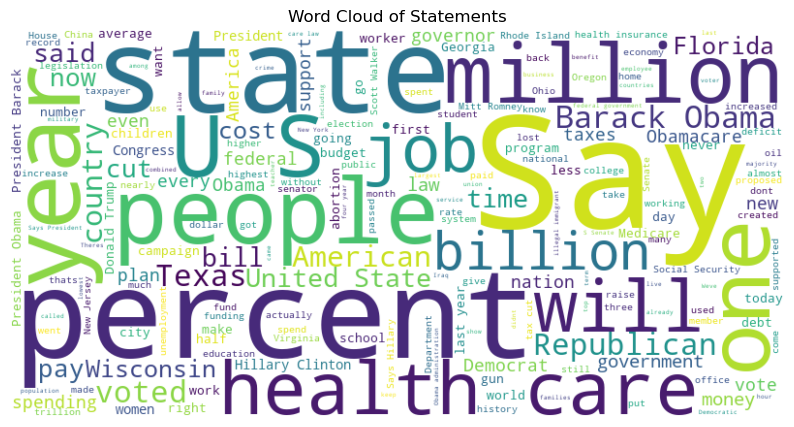

In [146]:
# make a plot for most frequent words in the statement column
!pip install wordcloud
from wordcloud import WordCloud

# Combine all statements into a single string
all_statements = ' '.join(train_data['statement'].values)

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400, background_color ='white').generate(all_statements)

# Display the WordCloud
plt.figure(figsize=(10, 10))

plt.imshow(wordcloud, interpolation='bilinear')

plt.axis('off')
plt.title('Word Cloud of Statements')
plt.show()

# EDA

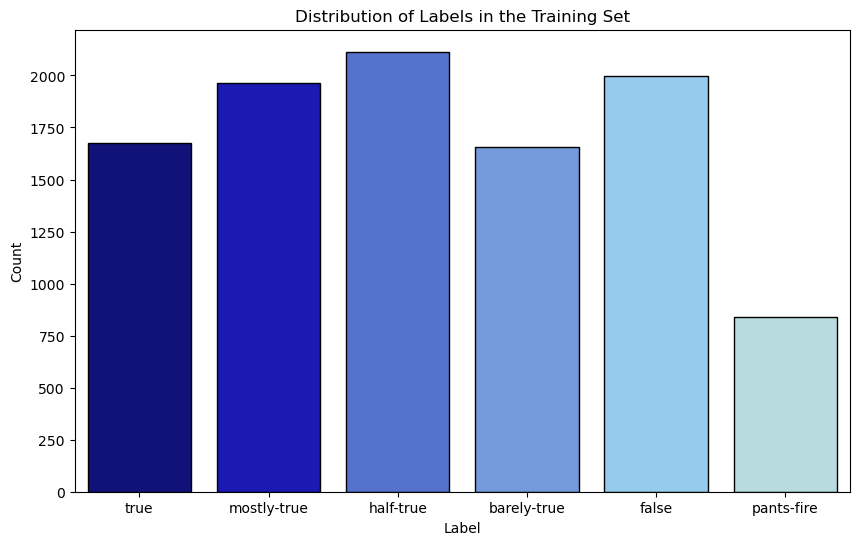

In [147]:
#Distribution of labels in train, test and validation

# order labels
label_order = ['true', 'mostly-true', 'half-true', 'barely-true', 'false', 'pants-fire']

# Define the custom color palette with a gradient from dark blue to light blue
custom_palette = ['#00008B', '#0000CD', '#4169E1', '#6495ED', '#87CEFA', '#B0E0E6']

# Plot the distribution of the labels with the custom color palette
plt.figure(figsize=(10, 6))
sns.countplot(data=train_data, x='label', palette=custom_palette, order=label_order,edgecolor = "black")
plt.title('Distribution of Labels in the Training Set')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

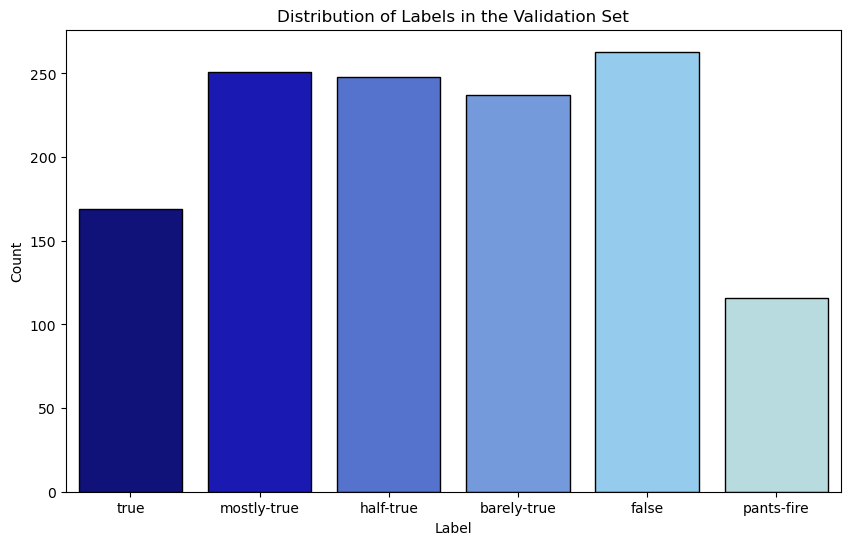

In [148]:
# same for validation data
plt.figure(figsize=(10, 6))
sns.countplot(data=valid_data, x='label', palette=custom_palette, order=label_order,edgecolor = "black")
plt.title('Distribution of Labels in the Validation Set')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

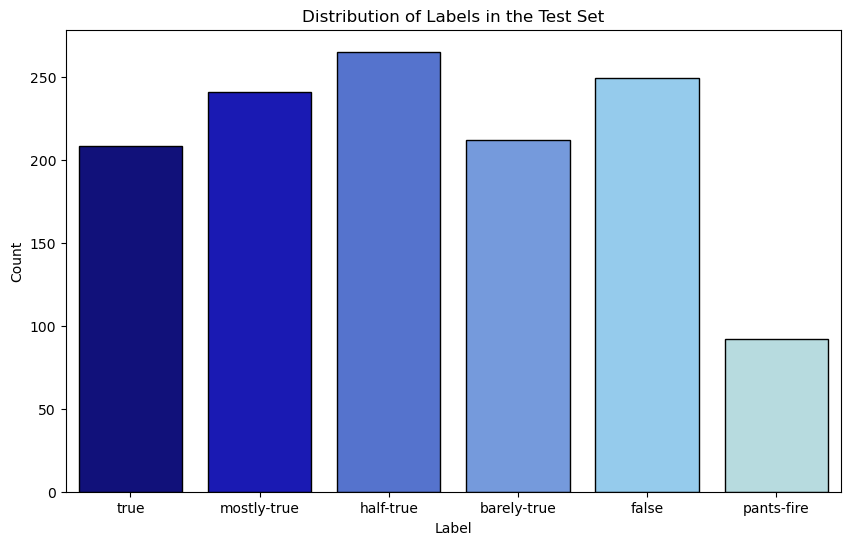

In [149]:
# same for test
plt.figure(figsize=(10, 6))
sns.countplot(data=test_data, x='label', palette=custom_palette, order=label_order,edgecolor = "black")
plt.title('Distribution of Labels in the Test Set')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

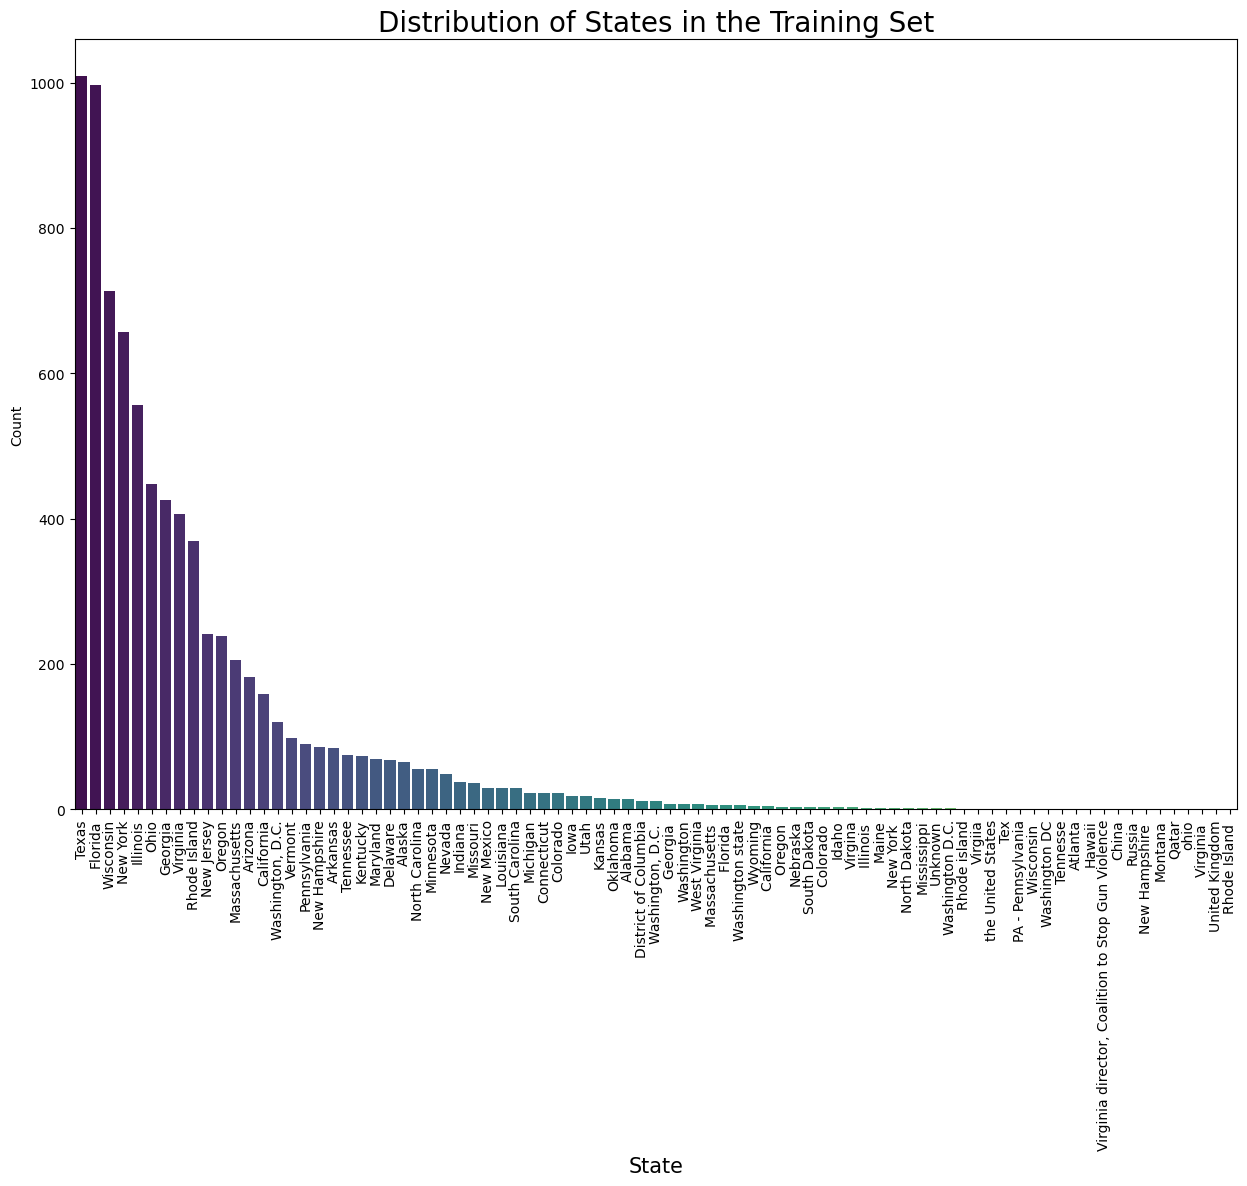

In [151]:
# Distribution of states in training data

plt.figure(figsize=(15, 10))
sns.countplot(data=train_data, x='state', palette='viridis', order=train_data['state'].value_counts().index)
plt.title('Distribution of States in the Training Set', size = 20)
plt.xlabel('State', size = 15)
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

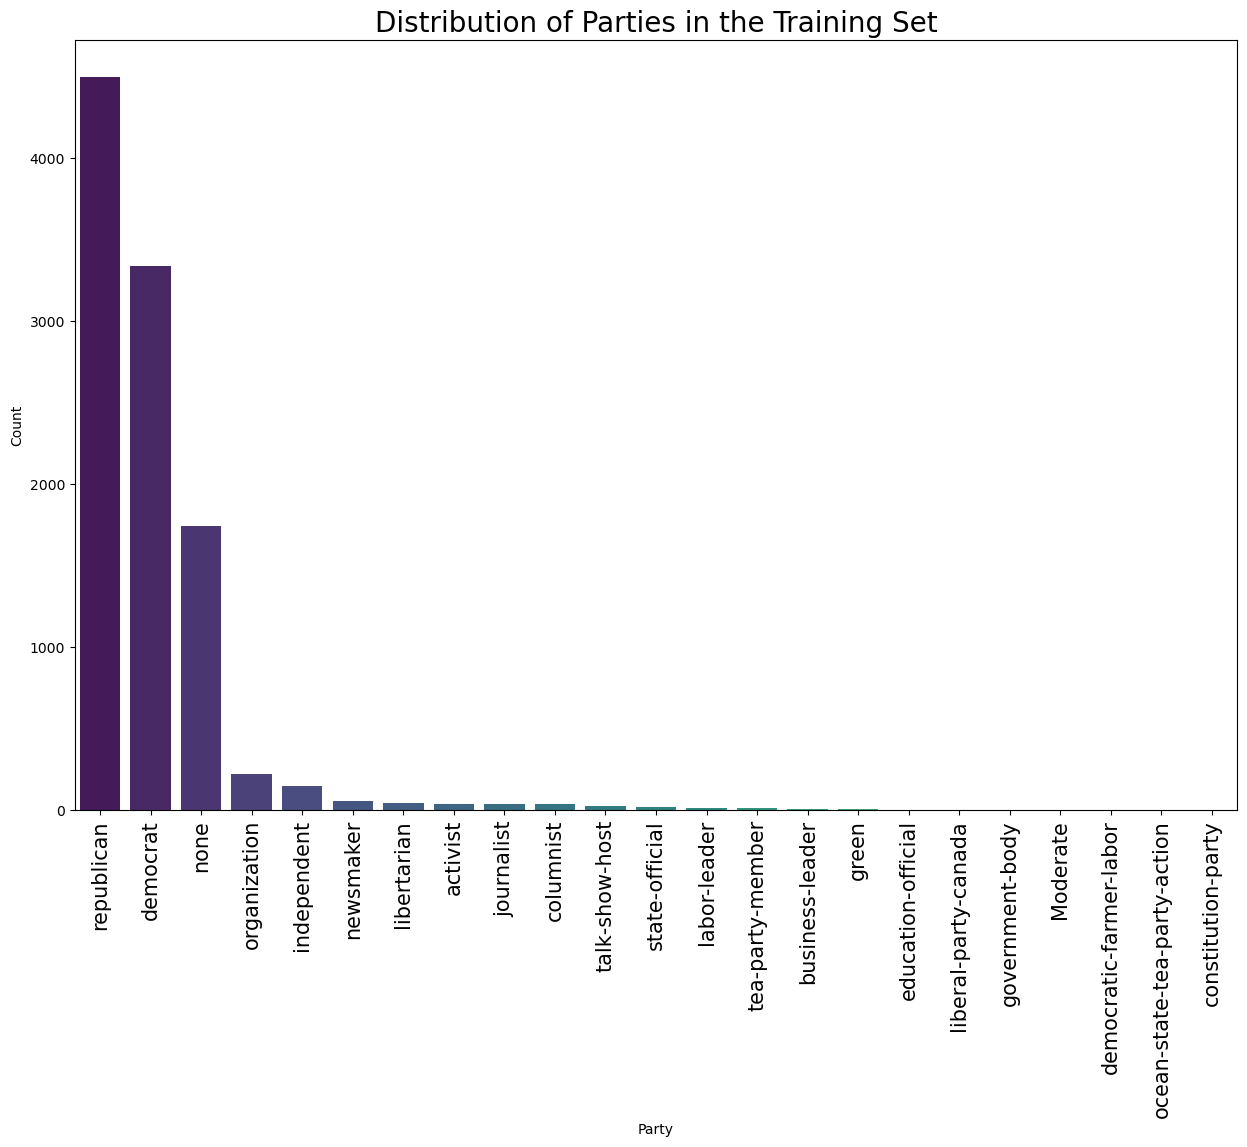

In [153]:
# Distribution of parties in training data

plt.figure(figsize=(15, 10))
sns.countplot(data=train_data, x='party', palette='viridis', order=train_data['party'].value_counts().index)
plt.title('Distribution of Parties in the Training Set', size = 20)
plt.xlabel('Party')
plt.ylabel('Count')
plt.xticks(rotation=90, size = 15)
plt.show()

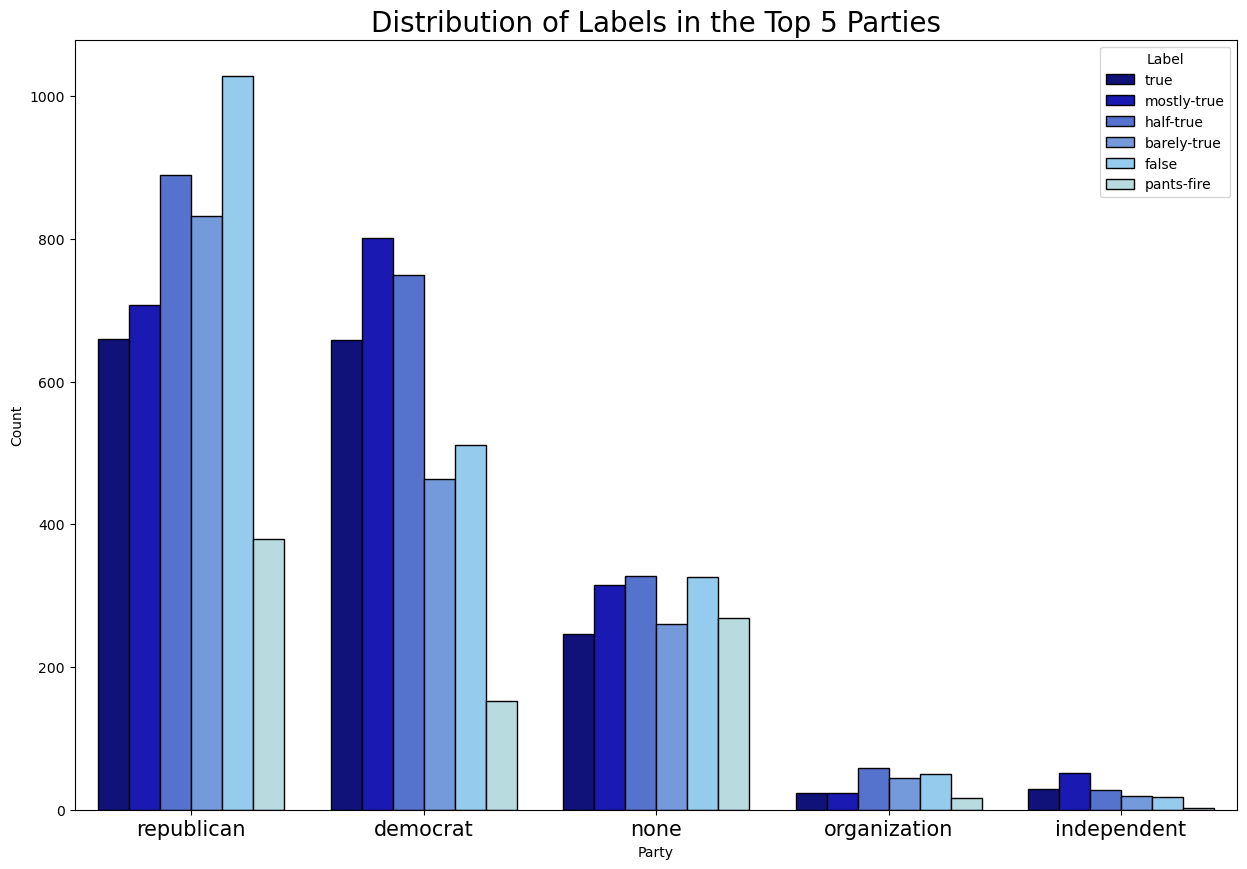

In [154]:
#distribution of the labels to the 5 top parties
plt.figure(figsize=(15, 10))
sns.countplot(data=train_data, x='party', hue='label', palette=custom_palette, order=train_data['party'].value_counts().index[:5], hue_order=label_order,edgecolor = "black")
plt.title('Distribution of Labels in the Top 5 Parties', size = 20)
plt.xlabel('Party')
plt.ylabel('Count')
plt.xticks(rotation=0, size = 15)
plt.legend(title='Label')
plt.show()

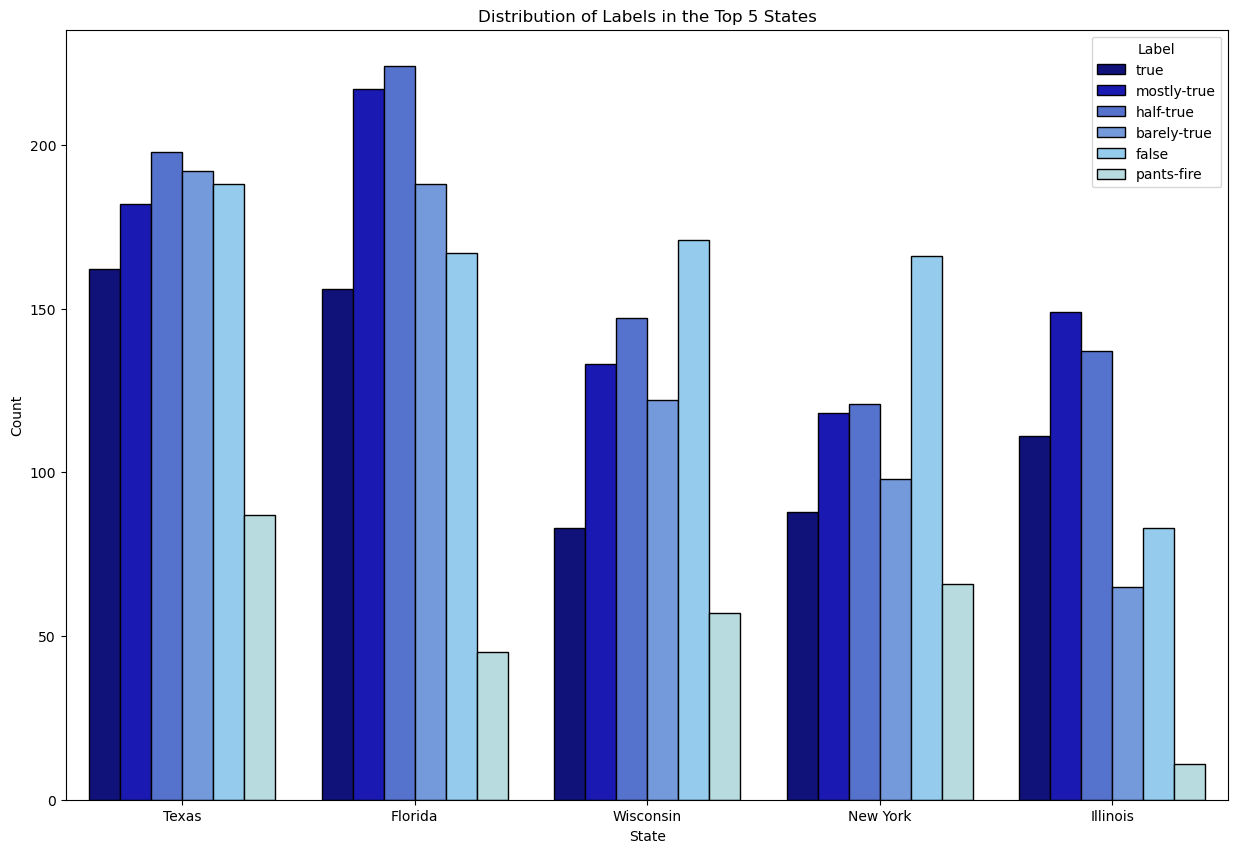

In [155]:
# distribution of the labels to the 5 top states
plt.figure(figsize=(15, 10))
sns.countplot(data=train_data, x='state', hue='label', palette=custom_palette, order=train_data['state'].value_counts().index[:5], hue_order=label_order,edgecolor = "black")
plt.title('Distribution of Labels in the Top 5 States')
plt.xlabel('State')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.legend(title='Label')
plt.show()

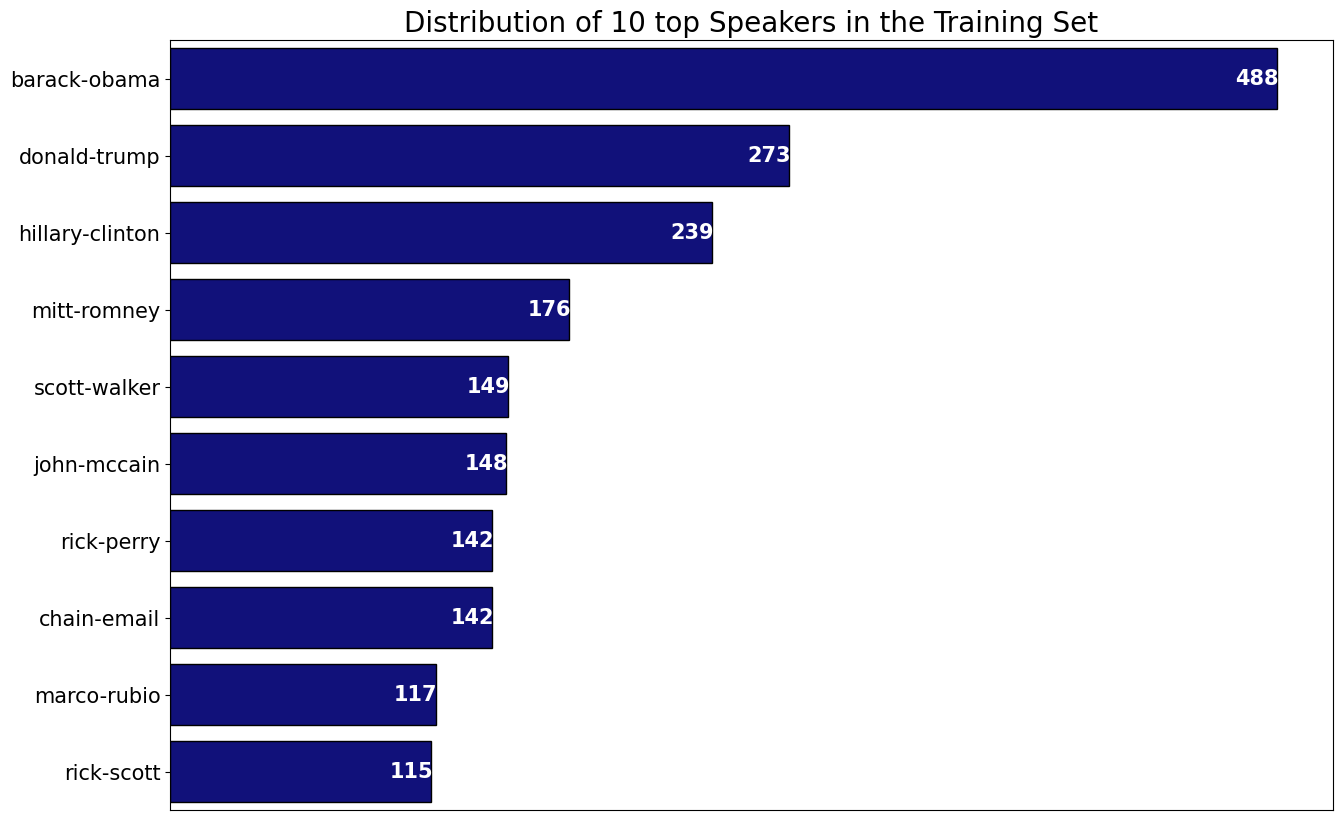

In [156]:
# 10 most frequent speakers in training set

plt.figure(figsize=(15, 10))
ax = sns.countplot(data=train_data, y='speaker', order=train_data['speaker'].value_counts().index[:10], color = "darkblue", edgecolor = "black")
plt.title('Distribution of 10 top Speakers in the Training Set', size = 20)
ax.bar_label(ax.containers[0], label_type='edge',padding = -30, color = "white", size = 15, fontweight='bold')
plt.xlabel(None)
plt.ylabel(None)
plt.yticks(size = 15)
ax.tick_params(bottom=False, labelbottom=False)
plt.show()

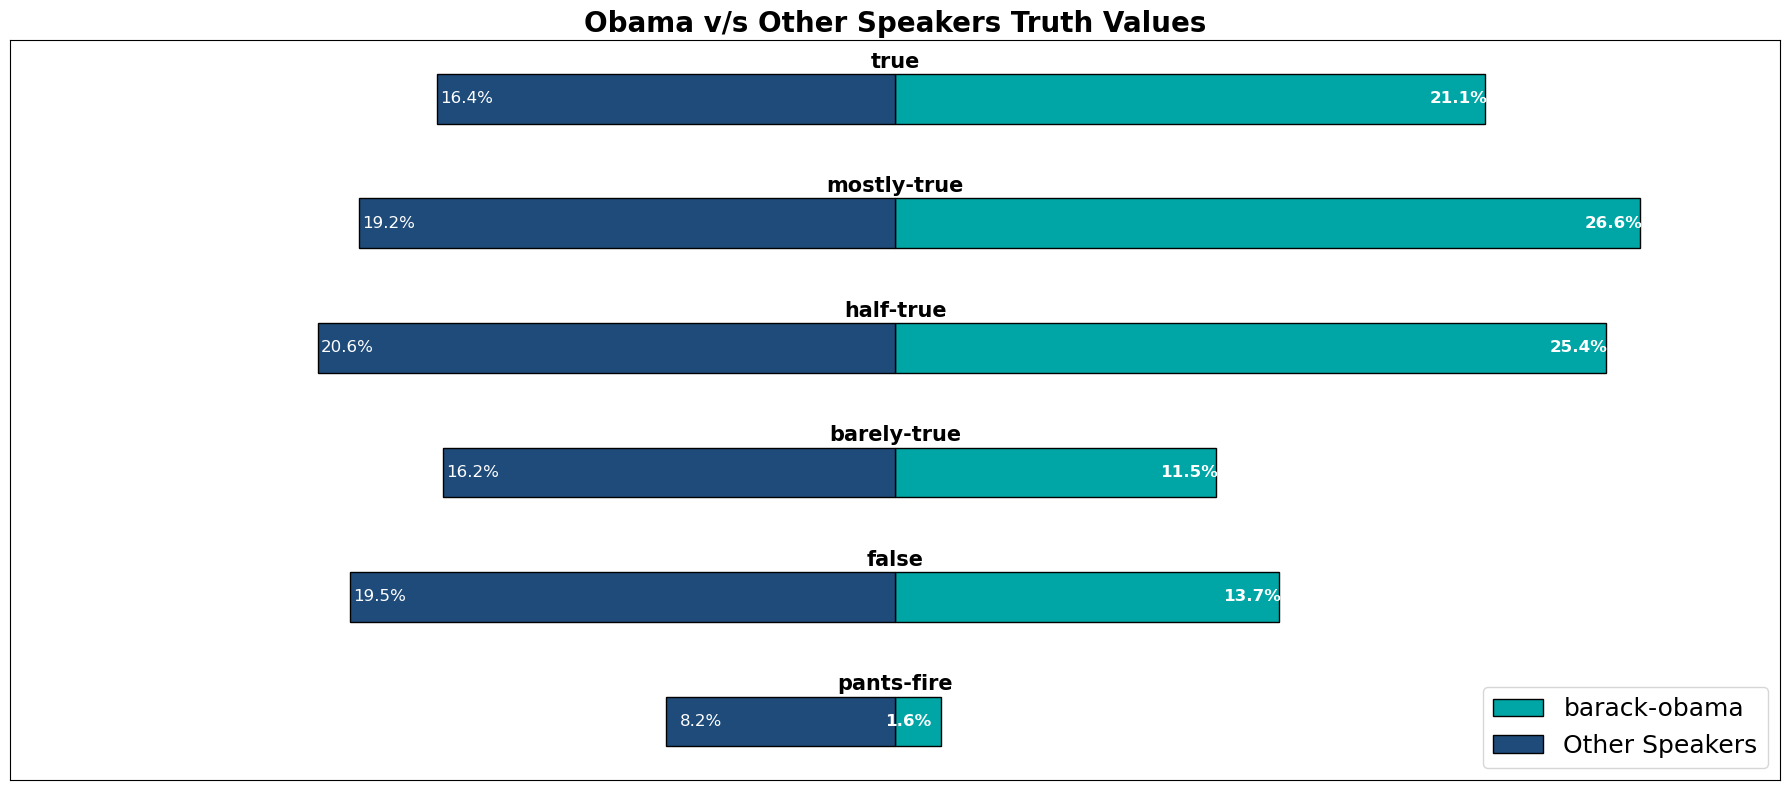

In [157]:
# Analyisis of top speaker labels vs other speakers in training set

top_speaker = train_data['speaker'].value_counts().idxmax()
top_speaker_data = train_data[train_data['speaker'] == top_speaker]

#compute average distribution of labels
average_distribution = train_data['label'].value_counts(normalize=True)
average_distribution = average_distribution.reindex(label_order)

fig, ax = plt.subplots( figsize=(18, 8))


# Top speaker's label distribution
average_top_speaker = top_speaker_data['label'].value_counts(normalize=True)
average_top_speaker = average_top_speaker.reindex(label_order)

# Plot top speaker and other speakers side by side
y_pos = np.arange(len(label_order))
ax.barh(y_pos, average_top_speaker.values, color='#00a6a6', label=top_speaker, height=0.4, align='center', edgecolor='black')
ax.barh(y_pos, -average_distribution.values, color='#1e4b7a', label='Other Speakers', height=0.4, align='center', edgecolor='black')
ax.legend(loc='lower right', fontsize = 18)
# Center the plot on zero
max_value = max(average_top_speaker.max() + 0.05, average_distribution.max() + 0.05) 
ax.set_xlim(-max_value, max_value)

# Add value labels on the bars
for i, (v1, v2) in enumerate(zip(average_top_speaker, average_distribution)):
    ax.text(v1 - 0.02 , i , f'{v1:.1%}', va='center', ha='left', fontweight='bold', color = 'white', size = 12)
    ax.text(-v2 + 0.02 , i , f'{v2:.1%}', va='center', ha='right', color = 'white', size = 12)
    
    # Add labels between bars
    ax.text(0, i-0.3, label_order[i], va='center', ha='center', fontweight='bold', size = 15)

ax.invert_yaxis()

# Remove x-axis ticks
ax.tick_params(bottom=False, labelbottom=False, left = False, labelleft=False)
ax.set_title('Obama v/s Other Speakers Truth Values', size = 20, fontweight='bold')

plt.tight_layout()
plt.show()

clean the data and check for missing values

In [159]:
# show me the NA number for each column
train_data.isnull().sum()


statement_id          0
label                 0
statement             0
subject               2
speaker               2
job_title          2898
state              2210
party                 2
barely_true_c         2
false_c               2
half_true_c           2
mostly_true_c         2
pants_on_fire_c       2
context             102
dtype: int64

In [161]:
valid_data.isnull().sum()

statement_id         0
label                0
statement            0
subject              0
speaker              0
job_title          345
state              279
party                0
barely_true_c        0
false_c              0
half_true_c          0
mostly_true_c        0
pants_on_fire_c      0
context             12
dtype: int64

In [162]:
test_data.isnull().sum()

statement_id         0
label                0
statement            0
subject              0
speaker              0
job_title          325
state              262
party                0
barely_true_c        0
false_c              0
half_true_c          0
mostly_true_c        0
pants_on_fire_c      0
context             17
dtype: int64

In [164]:
# take off the 2 rows that cintain in all the columns NA
# show me the row with the NA in the spkear column
train_data[train_data.speaker.isnull()]
# drop the row with the NA in the spkear column and reset the index
train_data.dropna(subset=['speaker'], inplace=True)
train_data.reset_index(drop=True, inplace=True)
train_data.isnull().sum()

statement_id          0
label                 0
statement             0
subject               0
speaker               0
job_title          2896
state              2208
party                 0
barely_true_c         0
false_c               0
half_true_c           0
mostly_true_c         0
pants_on_fire_c       0
context             100
dtype: int64

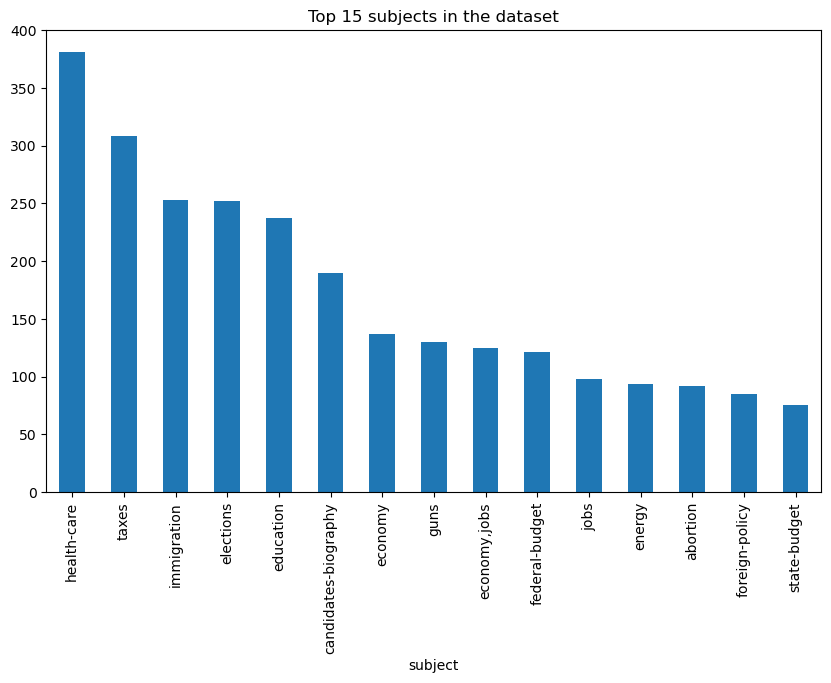

In [166]:
# show the distrubution of the the subject column show the top 15

train_data['subject'].value_counts().head(15).plot(kind='bar', figsize=(10, 6), title='Top 15 subjects in the dataset')
plt.show()

In [167]:
# print the rows with NA values
train_data[train_data['job_title'].isnull()]

statement_id        label  \
3        1123.json        false   
4        9028.json    half-true   
6        2342.json  barely-true   
8        5602.json    half-true   
13       8616.json  mostly-true   
...            ...          ...   
10232    1592.json    half-true   
10233    5473.json  mostly-true   
10234    3408.json  mostly-true   
10235    3959.json    half-true   
10236    2253.json        false   

                                               statement  \
3      Health care reform legislation is likely to ma...   
4      The economic turnaround started at the end of ...   
6      Jim Dunnam has not lived in the district he re...   
8      However, it took $19.5 million in Oregon Lotte...   
13     The economy bled $24 billion due to the govern...   
...                                                  ...   
10232  Under the ruling of the Supreme Court, any lob...   
10233  There are a larger number of shark attacks in ...   
10234  Democrats have now become the party of the [At...   
10235  Says an alternative to Social Security that op...   
10236  On lifting the U.S. Cuban embargo and allowing...   

                                  subject                 speaker job_title  \
3                             health-care            blog-posting       NaN   
4                            economy,jobs           charlie-crist       NaN   
6                    candidates-biography  republican-party-texas       NaN   
8                                    jobs          oregon-lottery       NaN   
13     economy,federal-budget,health-care              doonesbury       NaN   
...                                   ...                     ...       ...   
10232              corporations,elections           david-axelrod       NaN   
10233                   animals,elections            aclu-florida       NaN   
10234                           elections             alan-powell       NaN   
10235          retirement,social-security             herman-cain       NaN   
10236              florida,foreign-policy             jeff-greene       NaN   

         state         party  barely_true_c  false_c  half_true_c  \
3          NaN          none            7.0     19.0          3.0   
4      Florida      democrat           15.0      9.0         20.0   
6        Texas    republican            3.0      1.0          1.0   
8          NaN  organization            0.0      0.0          1.0   
13         NaN          none            0.0      0.0          2.0   
...        ...           ...            ...      ...          ...   
10232      NaN      democrat            2.0      1.0          6.0   
10233  Florida          none            0.0      1.0          1.0   
10234  Georgia    republican            0.0      0.0          0.0   
10235  Georgia    republican            4.0     11.0          5.0   
10236  Florida      democrat            3.0      1.0          3.0   

       mostly_true_c  pants_on_fire_c  \
3                5.0             44.0   
4               19.0              2.0   
6                3.0              1.0   
8                0.0              1.0   
13               4.0              0.0   
...              ...              ...   
10232            7.0              0.0   
10233            1.0              0.0   
10234            1.0              0.0   
10235            3.0              3.0   
10236            0.0              0.0   

                                                 context  
3                                         a news release  
4                                    an interview on CNN  
6                                       a press release.  
8                                             a website   
13               a Doonesbury strip in the Sunday comics  
...                                                  ...  
10232                    an interview on ABC's This Week  
10233                  interview on "The Colbert Report"  
10234                                       an interview  
102

In [168]:
# for thw rows with NA values in the job_title column, print the unique values of the context column
train_data[train_data['job_title'].isnull()]['context'].unique()

array(['a news release', 'an interview on CNN', 'a press release.', ...,
       'a recorded telephone message to Cranston residents',
       'interview on "The Colbert Report"',
       "a televised debate on Miami's WPLG-10 against Kendrick Meek."],
      dtype=object)

# Text Preprocessing
Next, preprocess the text data:

In [169]:
# Download necessary NLTK data files
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

# Preprocess the text with handling for hyphenated words
def preprocess_text(text):
    tokens = word_tokenize(text.lower())
    # Allow hyphenated words by checking if the word is either alphanumeric or contains hyphens
    tokens = [word for word in tokens if all(part.isalnum() for part in word.split('-')) and word not in stopwords.words('english')]
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return tokens

def preprocess_dataset(dataset):
    # Apply preprocessing steps on each column
    dataset['processed_text'] = dataset['statement'].apply(preprocess_text)
    dataset['processed_job_title'] = dataset['job_title'].apply(lambda x: preprocess_text(x) if isinstance(x, str) else [])
    dataset['processed_subject'] = dataset['subject'].apply(lambda x: preprocess_text(x) if isinstance(x, str) else [])
    dataset['processed_context'] = dataset['context'].apply(lambda x: preprocess_text(x) if isinstance(x, str) else [])
    return dataset

# Preprocess all datasets
train_data = preprocess_dataset(train_data)
valid_data = preprocess_dataset(valid_data)
test_data = preprocess_dataset(test_data)


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sigal\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sigal\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\sigal\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Feature Engineering for Text Data

In [170]:
# # Function to average word vectors of column values
# def get_average_word2vec(tokens, model, vector_size):
#     if len(tokens) < 1:
#         return np.zeros(vector_size)
#     vecs = [model.wv[token] for token in tokens if token in model.wv]
#     if len(vecs) == 0:
#         return np.zeros(vector_size)
#     return np.mean(vecs, axis=0)

In [22]:
# statement - will be used to generate new features

In [182]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import numpy as np

def generate_doc2vec_embeddings(dataset, column_name, vector_size=100, epochs=20, dm=1):
    """
    Generate Doc2Vec embeddings for a specific column in the dataset.
    
    Parameters:
    dataset (DataFrame): The dataset containing the column to embed.
    column_name (str): The name of the column to embed (e.g., 'processed_subject').
    vector_size (int): The size of the output embedding vector. Default is 100.
    epochs (int): The number of training iterations. Default is 20.
    
    Returns:
    DataFrame: The dataset with an added column containing the Doc2Vec embeddings.
    """
    # Prepare TaggedDocuments for the Doc2Vec model
    documents = [TaggedDocument(words=row, tags=[i]) for i, row in enumerate(dataset[column_name])]
    
    # Train the Doc2Vec model
    doc2vec_model = Doc2Vec(documents, vector_size=vector_size, window=5, min_count=1, workers=4, epochs=epochs, dm=dm)
    
    # Generate and add embeddings to the dataset
    dataset[f'{column_name}_embedding'] = dataset[column_name].apply(lambda x: doc2vec_model.infer_vector(x))
    
    return dataset


In [185]:
# Apply the function to generate embeddings for 'processed_subject' in each dataset
train_data = generate_doc2vec_embeddings(train_data, 'processed_subject', dm=0)
valid_data = generate_doc2vec_embeddings(valid_data, 'processed_subject', dm=0)
test_data = generate_doc2vec_embeddings(test_data, 'processed_subject', dm=0)


# Display the first few rows to verify the results
display(train_data[['processed_subject', 'processed_subject_embedding']].head())
display(valid_data[['processed_subject', 'processed_subject_embedding']].head())
display(test_data[['processed_subject', 'processed_subject_embedding']].head())

# add subject embeddings mean as feature
train_data['subject_embedding_mean'] = train_data['processed_subject_embedding'].apply(np.mean)
valid_data['subject_embedding_mean'] = valid_data['processed_subject_embedding'].apply(np.mean)
test_data['subject_embedding_mean'] = test_data['processed_subject_embedding'].apply(np.mean)


processed_subject  \
0                              [abortion]   
1  [energy, history, job-accomplishments]   
2                        [foreign-policy]   
3                           [health-care]   
4                          [economy, job]   

                         processed_subject_embedding  
0  [-0.032116, -0.034870386, -0.007974757, 0.0082...  
1  [-0.07094687, -0.07282489, -0.0120815495, 0.02...  
2  [-0.040598538, -0.038979907, -0.0072499844, 0....  
3  [-0.0119996425, -0.01508317, 0.0019254346, 0.0...  
4  [-0.012803605, -0.0079843635, -0.002381368, 0....

processed_subject  \
0                       [economy, job]   
1  [obama-birth-certificate, religion]   
2    [campaign-finance, congress, tax]   
3                            [poverty]   
4                  [economy, stimulus]   

                         processed_subject_embedding  
0  [-0.0014100347, 0.0035301158, -0.0005199443, -...  
1  [0.007155892, -0.0001746709, 0.0020500678, -0....  
2  [0.002676157, -0.0022403577, 0.005361404, -0.0...  
3  [0.0024763993, -0.0043697744, 0.0040061045, -0...  
4  [0.0019236861, -0.0022911709, -0.0018593901, 0...

processed_subject  \
0                                      [immigration]   
1                                              [job]   
2                 [military, veteran, voting-record]   
3  [medicare, message-machine-2012, campaign-adve...   
4  [campaign-finance, legal-issues, campaign-adve...   

                         processed_subject_embedding  
0  [0.0031359224, -0.0013512033, 0.0050372644, -0...  
1  [-0.0005512723, -0.0014068851, 0.0017397169, 0...  
2  [-0.006563032, -0.0030500896, 0.007858882, -0....  
3  [-0.0062035755, -0.0016422309, -0.0012294838, ...  
4  [-0.00714366, -0.0020942858, 0.006732989, -0.0...

In [187]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from adjustText import adjust_text

def plot_tsne_embeddings(dataset, embedding_column, label_column, subset_size=50, max_label_length=15, title='t-SNE Visualization', random_state=42, x_label='t-SNE 1', y_label='t-SNE 2'):
    """
    Plots the t-SNE embeddings for a given dataset with truncated labels.
    
    Parameters:
    dataset (DataFrame): The dataset containing embeddings.
    embedding_column (str): The name of the column with the embeddings.
    label_column (str): The name of the column for text annotations.
    subset_size (int): The number of points to sample and plot for visualization. Default is 50.
    max_label_length (int): Maximum length of the label to display. Default is 15 characters.
    title (str): The title of the plot. Default is 't-SNE Visualization'.
    random_state (int): The random seed for reproducibility. Default is 42.
    x_label (str): The label for the x-axis. Default is 't-SNE 1'.
    y_label (str): The label for the y-axis. Default is 't-SNE 2'.
    
    Returns:
    None. Displays the plot.
    """
    # ignore the NA values
    dataset1 = dataset.dropna(subset=[embedding_column, label_column])
    # Extract the embeddings and labels (text) from the dataset
    embeddings_filtered = np.array(dataset1[embedding_column].tolist())
    labels_filtered = dataset1[label_column].values
    
    # Truncate labels if they exceed max_label_length
    truncated_labels = [label if len(label) <= max_label_length else label[:max_label_length] + '...' for label in labels_filtered]
    
    # Reduce dimensionality to 2D using t-SNE
    tsne = TSNE(n_components=2, random_state=random_state)
    embeddings_2d = tsne.fit_transform(embeddings_filtered)
    
    # Sample a subset of the data for visualization
    indices = np.random.choice(range(len(embeddings_2d)), size=subset_size, replace=False)
    
    # Create a scatter plot of the embeddings
    plt.figure(figsize=(16, 12))  # Increased figure size for more space
    plt.scatter(embeddings_2d[indices, 0], embeddings_2d[indices, 1], c='blue', s=50, alpha=0.6)
    
    # Annotate the points with truncated labels
    texts = []
    for i in indices:
        texts.append(plt.text(embeddings_2d[i, 0], embeddings_2d[i, 1], truncated_labels[i], fontsize=12, ha='center', fontweight='bold'))
    
    # Adjust text to avoid overlap
    adjust_text(
        texts, 
        arrowprops=dict(arrowstyle='-', color='gray', lw=0.5),
        expand_text=(1.2, 1.4),  # Expands text label distance
        expand_points=(1.1, 1.3),  # Expands the points
        expand_objects=(1.1, 1.4),  # Expands objects around
        lim=1000  # Limits the maximum number of iterations
    )
    
    # Set title and axis labels
    plt.title(title, fontsize=20, fontweight='bold')
    plt.xlabel(x_label, fontsize=14)  # Set the x-axis label
    plt.ylabel(y_label, fontsize=14)  # Set the y-axis label
    plt.xticks([])
    plt.yticks([])
    plt.show()



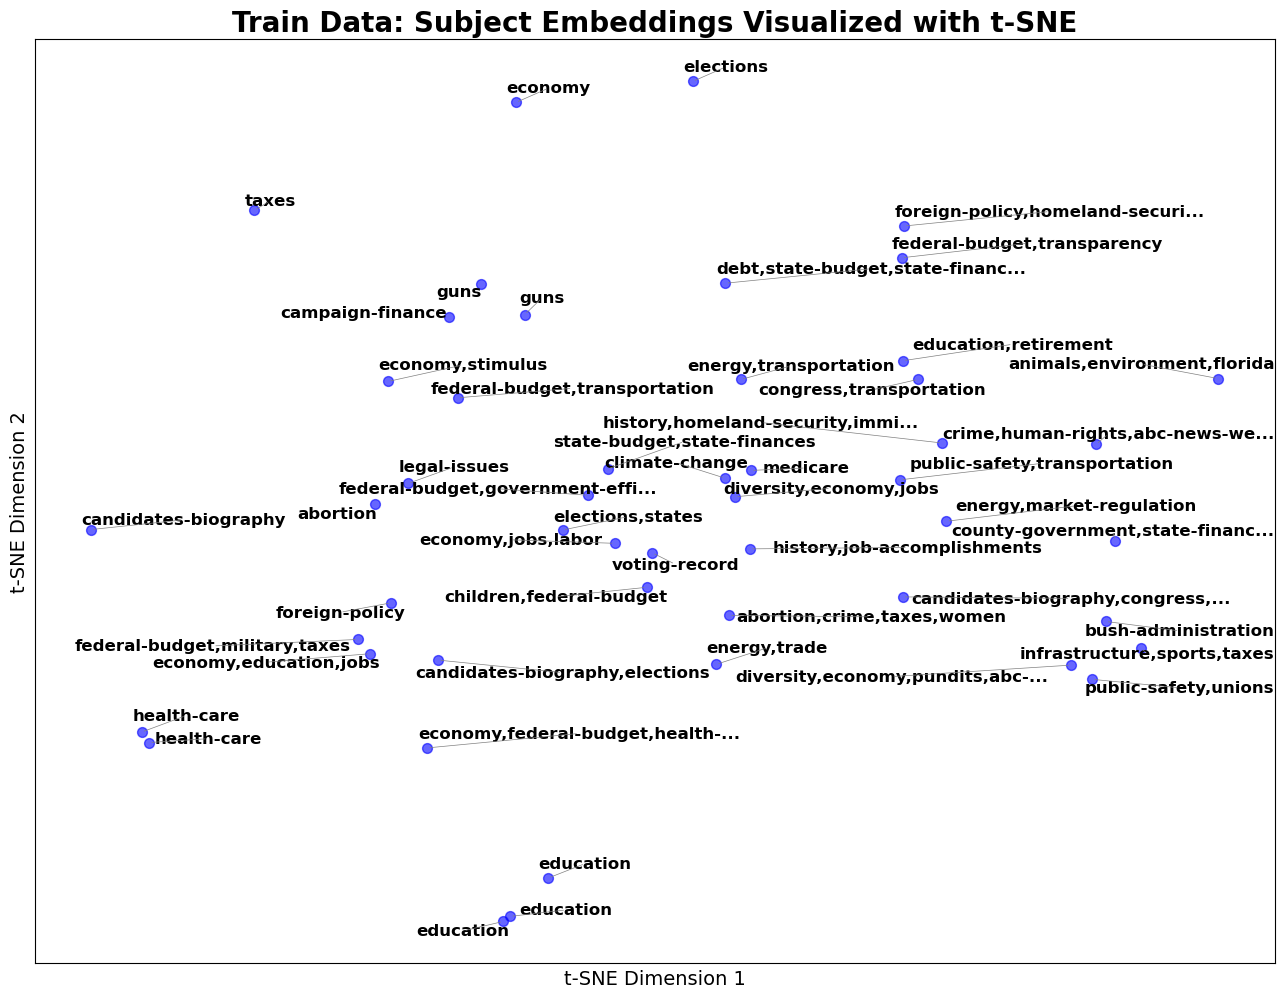

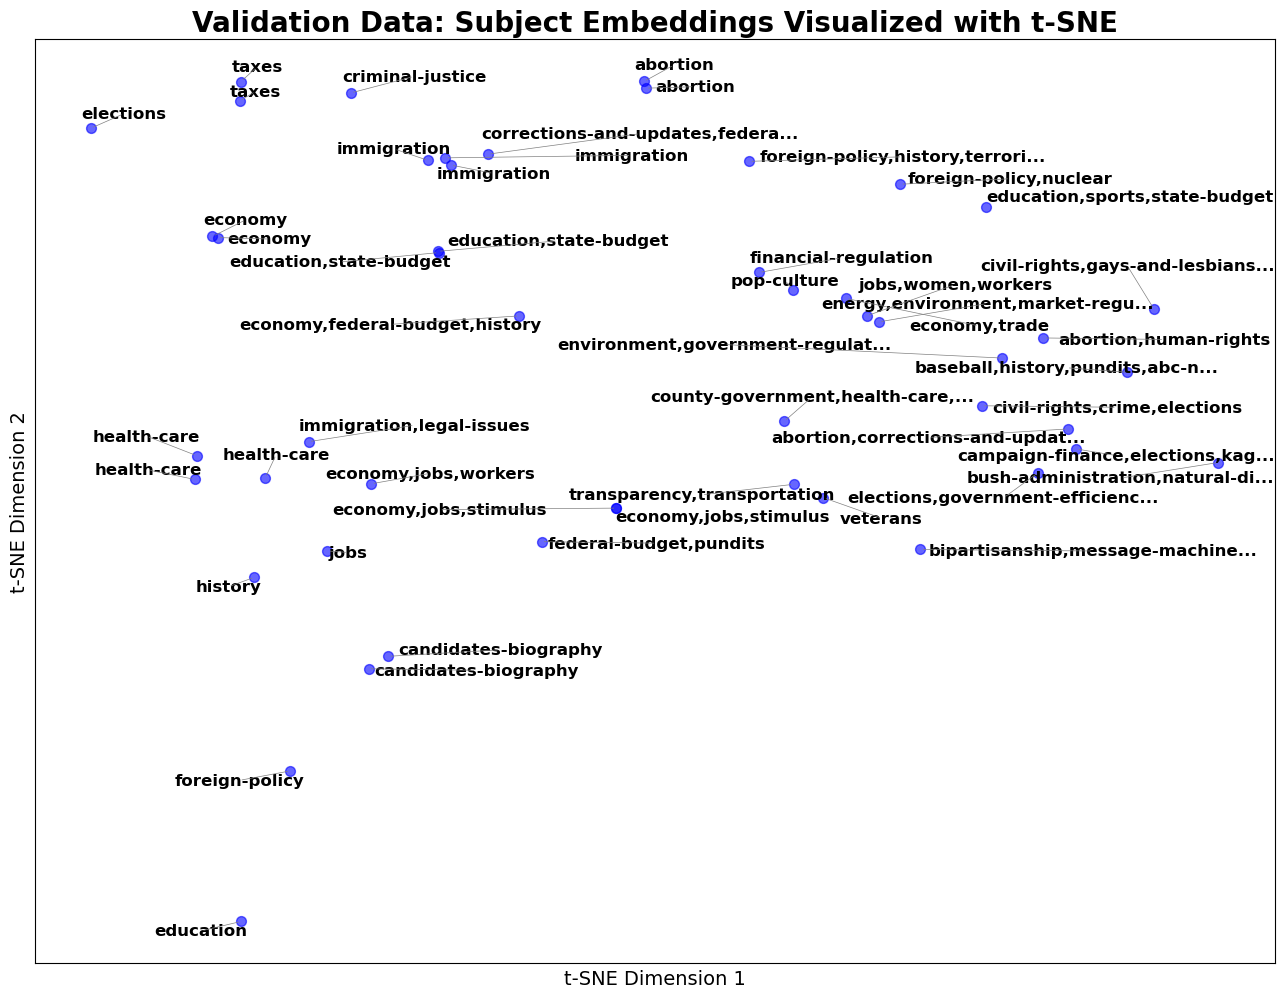

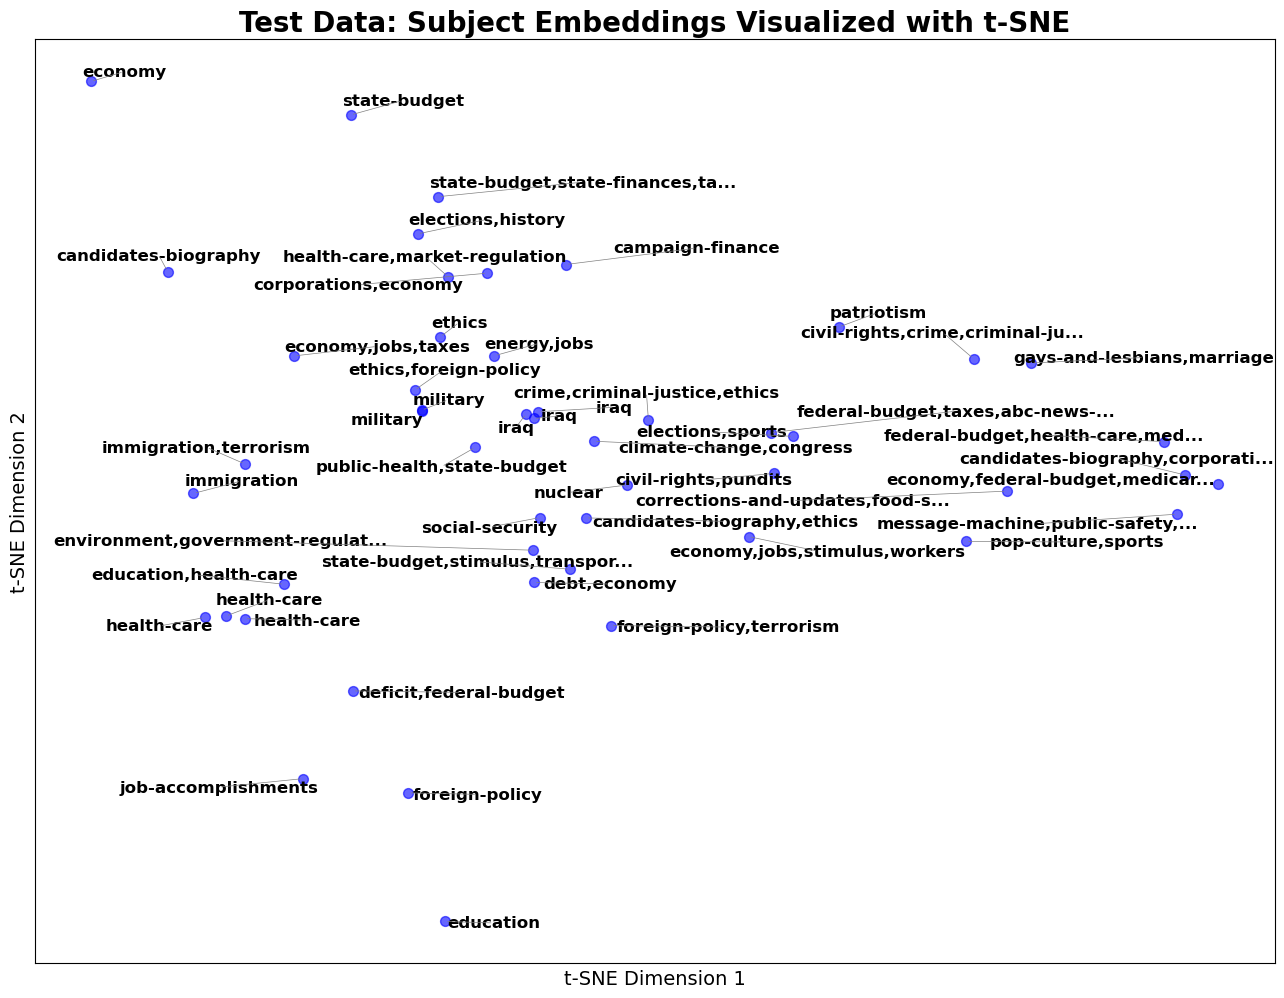

In [188]:
plot_tsne_embeddings(
    dataset=train_data, 
    embedding_column='processed_subject_embedding', 
    label_column='subject', 
    title='Train Data: Subject Embeddings Visualized with t-SNE',
    max_label_length=30,
    x_label='t-SNE Dimension 1', 
    y_label='t-SNE Dimension 2'  
)

plot_tsne_embeddings(
    dataset=valid_data, 
    embedding_column='processed_subject_embedding', 
    label_column='subject', 
    title='Validation Data: Subject Embeddings Visualized with t-SNE',
    max_label_length=30,
    x_label='t-SNE Dimension 1', 
    y_label='t-SNE Dimension 2'
)

plot_tsne_embeddings(
    dataset=test_data, 
    embedding_column='processed_subject_embedding', 
    label_column='subject', 
    title='Test Data: Subject Embeddings Visualized with t-SNE',
    max_label_length=30,
    x_label='t-SNE Dimension 1', 
    y_label='t-SNE Dimension 2'
)




In [28]:
# speaker - dont use it and use counts of the speaker labels

# Feature Engineering: Job Title Embeddings
Use doc2vec to create embeddings for the job titles

In [189]:
# Apply the function to generate Doc2Vec embeddings for 'processed_job_title' in each dataset
train_data = generate_doc2vec_embeddings(train_data, 'processed_job_title', dm=1)
valid_data = generate_doc2vec_embeddings(valid_data, 'processed_job_title', dm=1)
test_data = generate_doc2vec_embeddings(test_data, 'processed_job_title', dm =1)

# Display the first few rows to verify the results
display(train_data[['processed_job_title', 'processed_job_title_embedding']].head())
display(valid_data[['processed_job_title', 'processed_job_title_embedding']].head())
display(test_data[['processed_job_title', 'processed_job_title_embedding']].head())

# add job embeddings mean as feature
train_data['job_title_embedding_mean'] = train_data['processed_job_title_embedding'].apply(np.mean)
valid_data['job_title_embedding_mean'] = valid_data['processed_job_title_embedding'].apply(np.mean)
test_data['job_title_embedding_mean'] = test_data['processed_job_title_embedding'].apply(np.mean)


processed_job_title                      processed_job_title_embedding
0  [state, representative]  [-0.0051510027, -0.000565922, -0.0029365874, -...
1        [state, delegate]  [-0.008798128, 0.006731391, -0.05100731, -0.03...
2              [president]  [-0.0024603838, -0.0037301609, -0.016699132, -...
3                       []  [-0.001165382, 0.0021868348, 0.0045572286, -0....
4                       []  [-0.0041018585, 0.0021954267, -0.0020915293, -...

processed_job_title  \
0                           [representative]   
1                                         []   
2                           [representative]   
3  [member, state, board, higher, education]   
4                                [president]   

                       processed_job_title_embedding  
0  [-0.0021427916, -0.0048310403, 0.00088582374, ...  
1  [-0.0014675074, 0.00268391, -0.0019936352, 0.0...  
2  [-0.002137185, -0.0048196316, 0.00072517194, 0...  
3  [-0.016719222, -0.005382631, 0.017007213, -0.0...  
4  [-0.00018480372, -0.0018993826, -2.5893849e-05...

processed_job_title                      processed_job_title_embedding
0               [governor]  [-0.0040033814, -0.0019504012, -0.0026367328, ...
1  [state, representative]  [-0.0035326257, 0.0008686094, -0.0030408998, -...
2        [president-elect]  [0.0017502141, -0.0044098864, 3.300025e-05, -0...
3             [consultant]  [0.0010220412, -0.0009074882, 0.006894975, -0....
4                       []  [0.0044727433, -0.00015774966, -0.004354023, -...

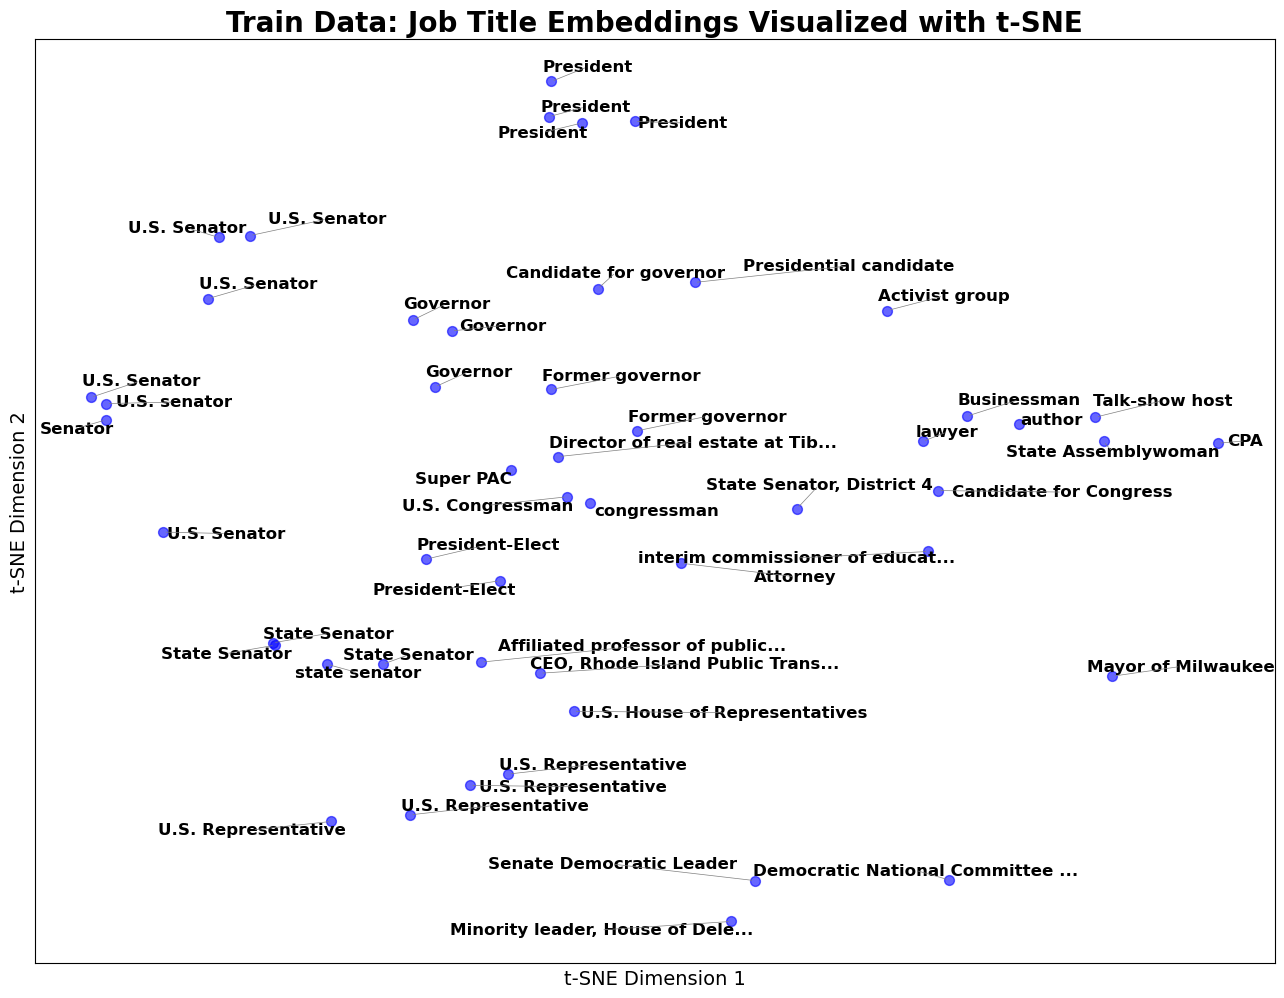

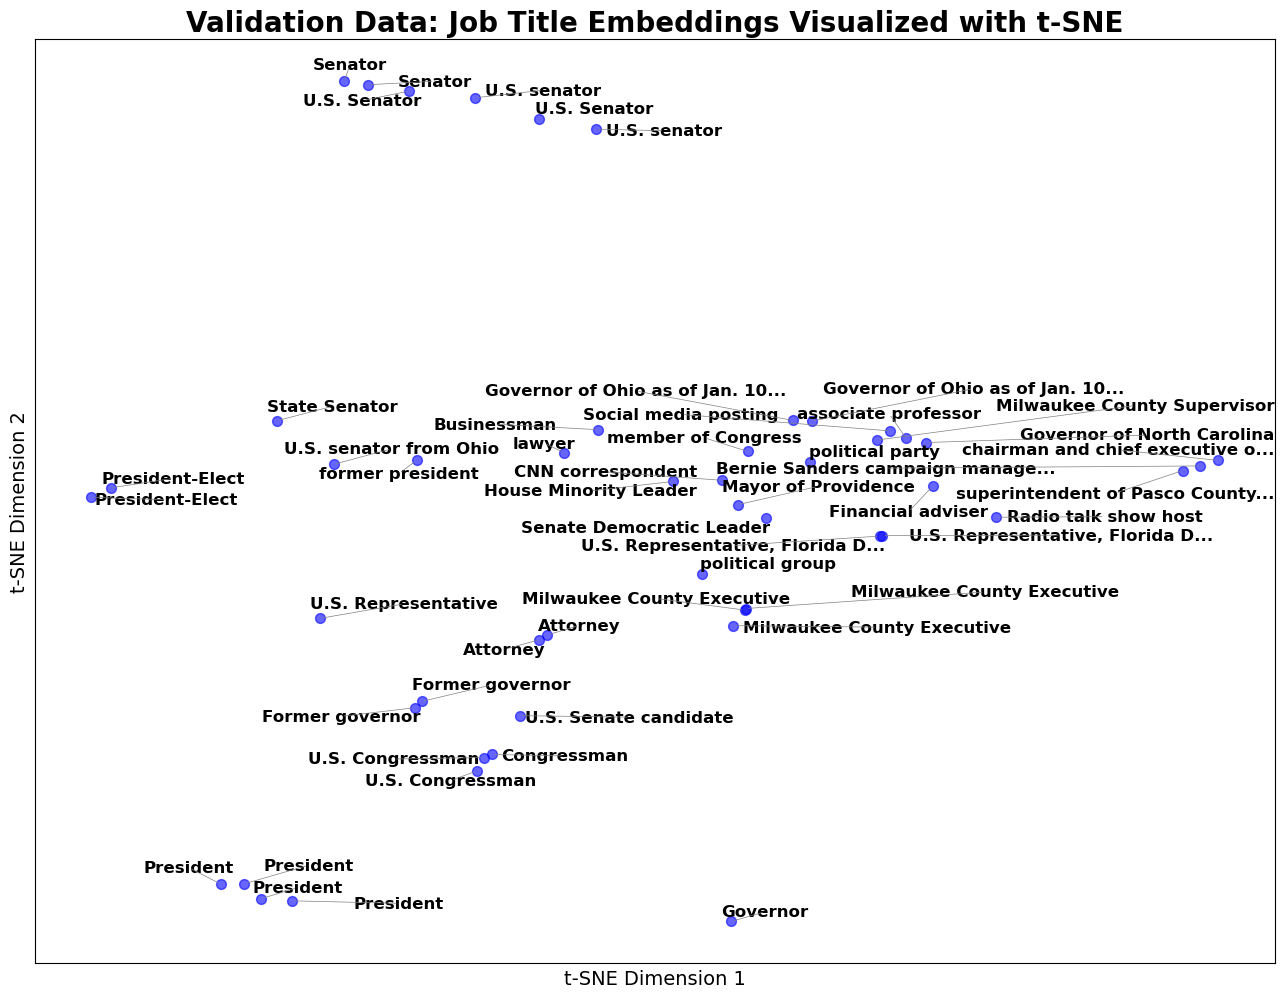

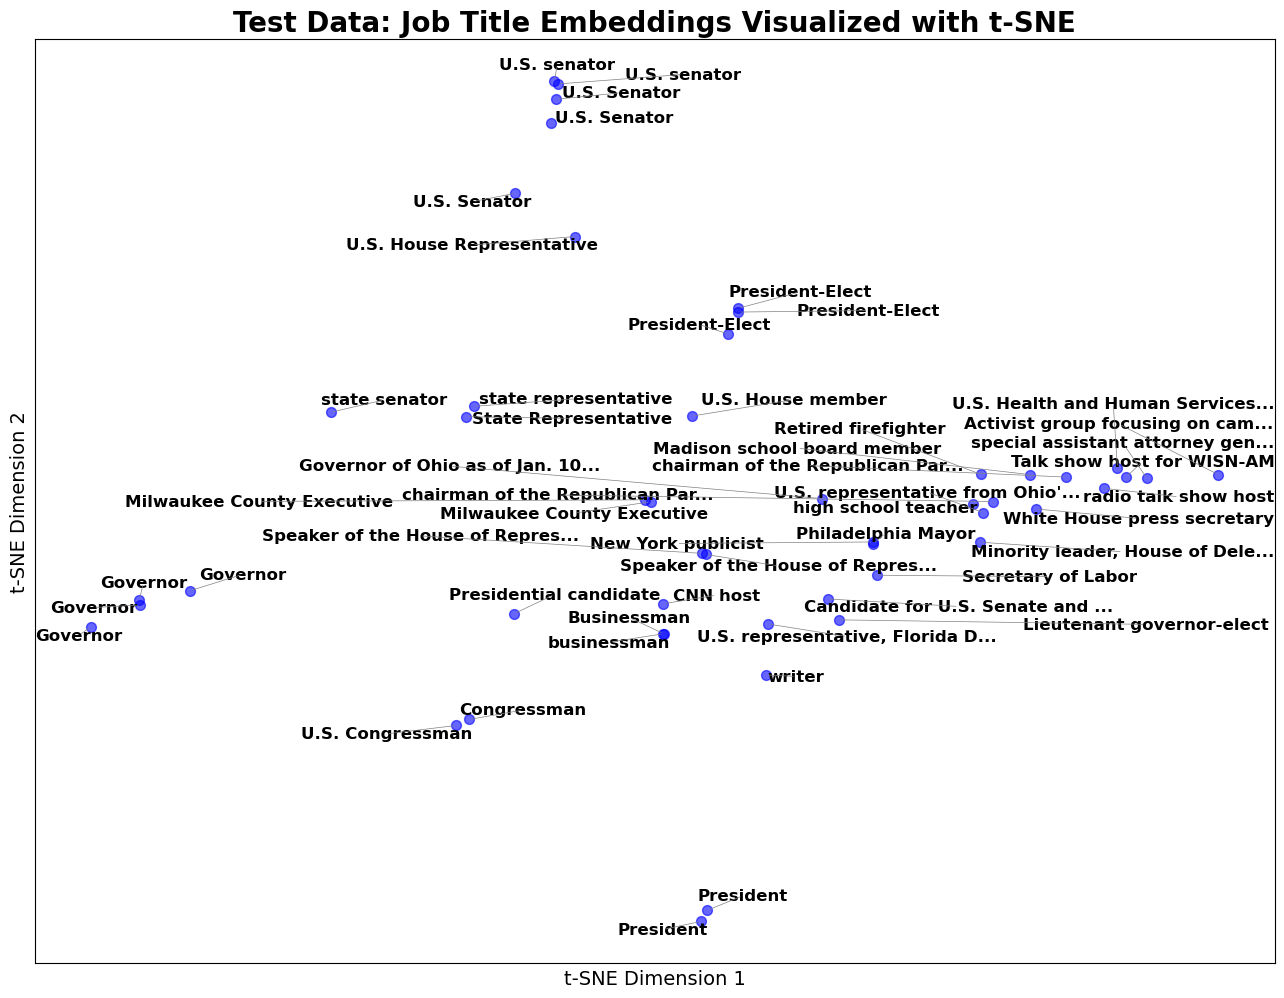

In [190]:
# use function to plot the t-SNE embeddings for the 'processed_job_title' column on train valid and test data
plot_tsne_embeddings(
    dataset=train_data, 
    embedding_column='processed_job_title_embedding', 
    label_column='job_title', 
    title='Train Data: Job Title Embeddings Visualized with t-SNE',
    max_label_length=30,
    x_label='t-SNE Dimension 1', 
    y_label='t-SNE Dimension 2'  
)

plot_tsne_embeddings(
    dataset=valid_data, 
    embedding_column='processed_job_title_embedding', 
    label_column='job_title', 
    title='Validation Data: Job Title Embeddings Visualized with t-SNE',
    max_label_length=30,
    x_label='t-SNE Dimension 1', 
    y_label='t-SNE Dimension 2'
)

plot_tsne_embeddings(
    dataset=test_data, 
    embedding_column='processed_job_title_embedding', 
    label_column='job_title', 
    title='Test Data: Job Title Embeddings Visualized with t-SNE',
    max_label_length=30,
    x_label='t-SNE Dimension 1', 
    y_label='t-SNE Dimension 2'
)

In [191]:
# state - Dont use it for model training.

def state_value_counts(datasets):
    """
    Function to return value counts of the 'state' column for each dataset.
    
    Parameters:
    datasets (dict): A dictionary containing datasets (e.g., {'train': train_data, 'valid': valid_data, 'test': test_data}).
    
    Returns:
    None: Prints the value counts for the 'state' column in each dataset.
    """
    for name, dataset in datasets.items():
        print(f"Value counts for 'state' in {name} dataset:")
        print(dataset['state'].value_counts())
        print("\n")

# Applying the function to the datasets
datasets = {'train': train_data, 'valid': valid_data, 'test': test_data}
state_value_counts(datasets)






Value counts for 'state' in train dataset:
state
Texas             1009
Florida            997
Wisconsin          713
New York           657
Illinois           556
                  ... 
Qatar                1
ohio                 1
Virginia             1
United Kingdom       1
Rhode Island         1
Name: count, Length: 83, dtype: int64


Value counts for 'state' in valid dataset:
state
Texas                   127
Florida                 117
New York                 87
Wisconsin                86
Ohio                     71
Illinois                 68
Georgia                  63
Virginia                 54
Rhode Island             41
New Jersey               34
Oregon                   30
Massachusetts            22
Arizona                  22
Arkansas                 12
Vermont                  12
Kentucky                 11
Washington, D.C.         11
California               11
Minnesota                11
North Carolina           11
New Hampshire            10
Maryland             

# Label Encoding for Party Affiliation
This section encodes the party affiliation of the politicians.

In [192]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Step 1: Create a set of unique 'party' values across train, valid, and test datasets
party_values = set(train_data['party'].unique()).union(set(valid_data['party'].unique())).union(set(test_data['party'].unique()))

# Step 2: Initialize the LabelEncoder and fit it on the combined unique party values
label_encoder = LabelEncoder()
label_encoder.fit(list(party_values))

# Step 3: Apply the same encoder to the 'party' column in each dataset and create a new 'party_encoded' column
train_data['party_encoded'] = label_encoder.transform(train_data['party'])
valid_data['party_encoded'] = label_encoder.transform(valid_data['party'])
test_data['party_encoded'] = label_encoder.transform(test_data['party'])

# Step 4: Display the first few rows of the train dataset to verify the encoding
display(train_data.head())



statement_id        label  \
0    2635.json        false   
1   10540.json    half-true   
2     324.json  mostly-true   
3    1123.json        false   
4    9028.json    half-true   

                                           statement  \
0  Says the Annies List political group supports ...   
1  When did the decline of coal start? It started...   
2  Hillary Clinton agrees with John McCain "by vo...   
3  Health care reform legislation is likely to ma...   
4  The economic turnaround started at the end of ...   

                              subject         speaker             job_title  \
0                            abortion    dwayne-bohac  State representative   
1  energy,history,job-accomplishments  scott-surovell        State delegate   
2                      foreign-policy    barack-obama             President   
3                         health-care    blog-posting                   NaN   
4                        economy,jobs   charlie-crist                   NaN   

      state       party  barely_true_c  false_c  ...      processed_job_title  \
0     Texas  republican            0.0      1.0  ...  [state, representative]   
1  Virginia    democrat            0.0      0.0  ...        [state, delegate]   
2  Illinois    democrat           70.0     71.0  ...              [president]   
3       NaN        none            7.0     19.0  ...                       []   
4   Florida    democrat           15.0      9.0  ...                       []   

                        processed_subject  processed_context  \
0                              [abortion]           [mailer]   
1  [energy, history, job-accomplishments]    [floor, speech]   
2                        [foreign-policy]           [denver]   
3                           [health-care]    [news, release]   
4                          [economy, job]   [interview, cnn]   

                         processed_subject_embedding subject_embedding_mean  \
0  [-0.032116, -0.034870386, -0.007974757, 0.0082...              -0.001117   
1  [-0.07094687, -0.07282489, -0.0120815495, 0.02...              -0.001864   
2  [-0.040598538, -0.038979907, -0.0072499844, 0....              -0.001106   
3  [-0.0119996425, -0.01508317, 0.0019254346, 0.0...              -0.000096   
4  [-0.012803605, -0.0079843635, -0.002381368, 0....              -0.000229   

                       processed_job_title_embedding job_title_embedding_mean  \
0  [-0.0051510027, -0.000565922, -0.0029365874, -...                 0.000574   
1  [-0.008798128, 0.006731391, -0.05100731, -0.03...                -0.002054   
2  [-0.0024603838, -0.0037301609, -0.016699132, -...                -0.000946   
3  [-0.001165382, 0.0021868348, 0.0045572286, -0....                 0.000511   
4  [-0.0041018585, 0.0021954267, -0.0020915293, -...                -0.000062   

  party_encoded                        processed_context_embedding  \
0            20  [-0.052293975, -0.006678892, -0.030356085, -0....   
1             6  [-0.04032467, -0.00074172864, 0.005267453, -0....   
2             6  [-0.076376975, -0.011585314, 0.0055075125, -0....   
3            17  [-0.021670507, -0.007932882, 0.028450597, 0.01...   
4             6  [-0.0394098, 0.0061081834, 0.0072728856, -0.01...   

   context_embedding_mean  
0                0.001508  
1                0.002570  
2                0.003993  
3                0.002329  
4                0.003909  

[5 rows x 25 columns]

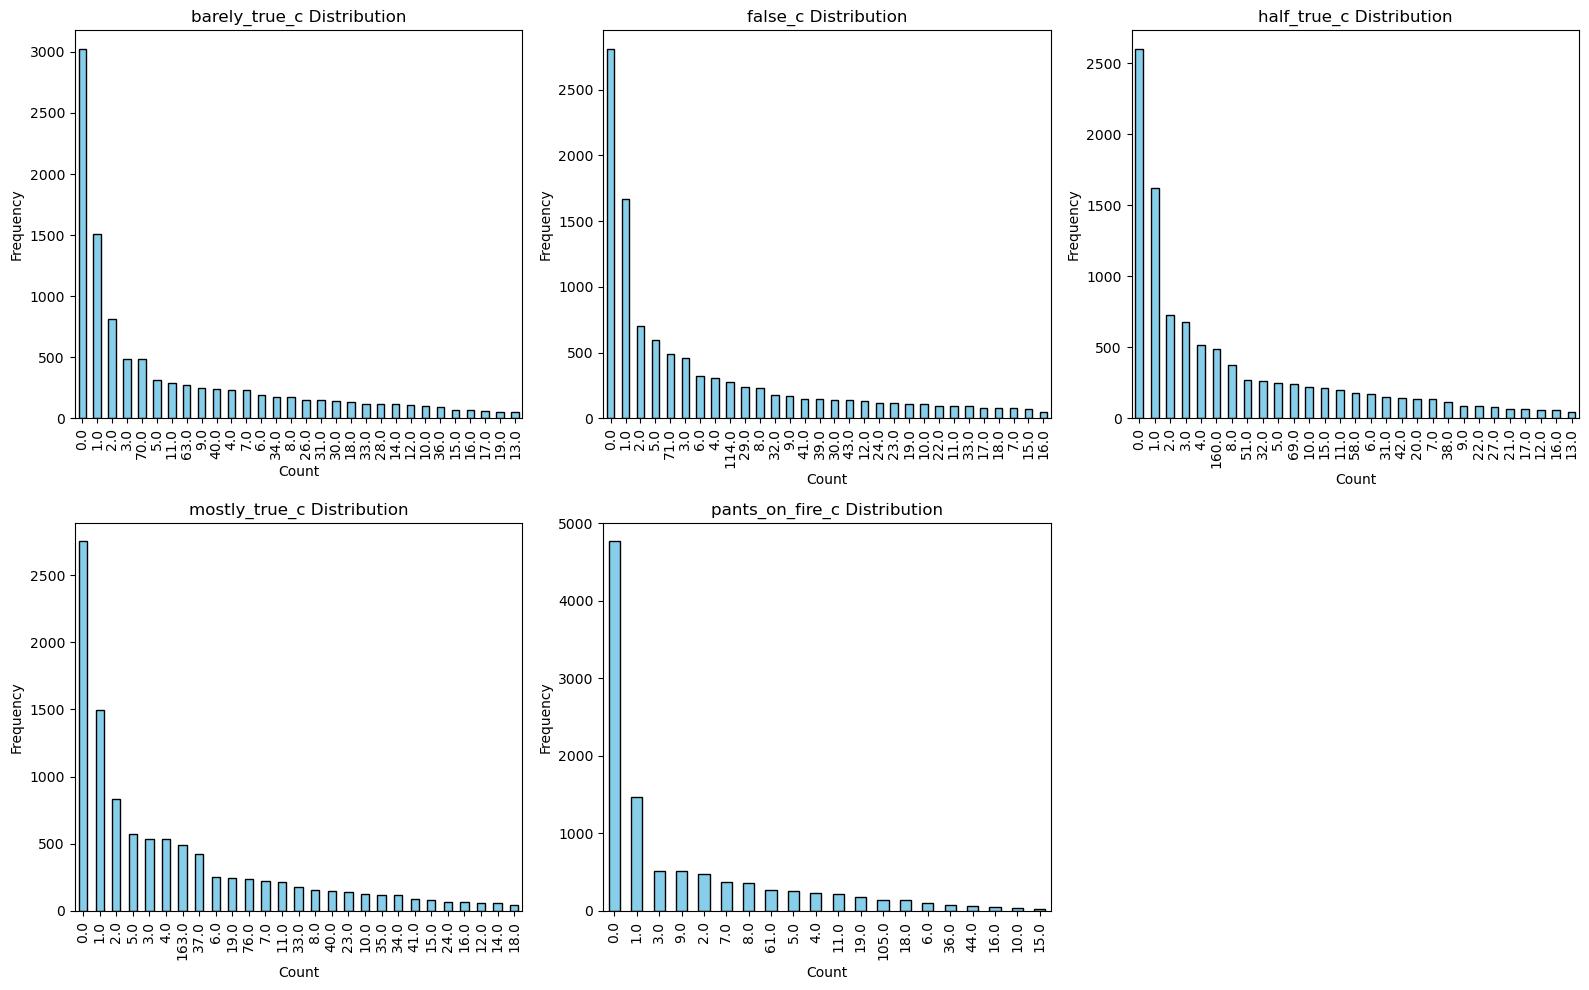

In [193]:
# counts of the speaker labels - use as is
# show the counts distribution of all count columns
count_columns = ['barely_true_c', 'false_c', 'half_true_c', 'mostly_true_c', 'pants_on_fire_c']

def plot_count_distribution(dataset, count_columns):
    
    # Initialize the figure
    plt.figure(figsize=(16, 10))
    
    # Create a stacked bar plot for the count columns
    for i, column in enumerate(count_columns):
        plt.subplot(2, 3, i + 1)
        dataset[column].value_counts().plot(kind='bar', color='skyblue', edgecolor='black')
        plt.title(f'{column} Distribution')
        plt.xlabel('Count')
        plt.ylabel('Frequency')
    
    # Adjust the layout
    plt.tight_layout()
    plt.show()
    
# Plot the count distributions for the train dataset
plot_count_distribution(train_data, count_columns)


In [194]:
# context - docs2vec embedding

# Apply the function to generate embeddings for 'processed_context' in each dataset
train_data = generate_doc2vec_embeddings(train_data, 'processed_context', dm=1)
valid_data = generate_doc2vec_embeddings(valid_data, 'processed_context', dm=1)
test_data = generate_doc2vec_embeddings(test_data, 'processed_context', dm=1)

# Display the first few rows to verify the embeddings
display(train_data[['processed_context', 'processed_context_embedding']].head())
display(valid_data[['processed_context', 'processed_context_embedding']].head())
display(test_data[['processed_context', 'processed_context_embedding']].head())

# add job embeddings mean as feature
train_data['context_embedding_mean'] = train_data['processed_context_embedding'].apply(np.mean)
valid_data['context_embedding_mean'] = valid_data['processed_context_embedding'].apply(np.mean)
test_data['context_embedding_mean'] = test_data['processed_context_embedding'].apply(np.mean)

processed_context                        processed_context_embedding
0          [mailer]  [-0.028764818, 0.004761422, -0.038371272, -0.0...
1   [floor, speech]  [-0.014582993, 0.02358158, -0.008989753, -0.02...
2          [denver]  [-0.041295916, -0.0024500946, -0.02588919, -0....
3   [news, release]  [-0.017568901, -0.013421054, 0.0046501067, -0....
4  [interview, cnn]  [-0.009786735, -5.8456208e-05, -0.0069178035, ...

processed_context                        processed_context_embedding
0  [interview, abc17, news]  [-0.0021827384, 0.0038866247, 0.009497483, -0....
1                        []  [-0.0028595966, -0.0011618695, -0.00039847492,...
2      [way, mean, hearing]  [-0.008454849, 0.014033571, 0.019142494, -0.02...
3        [opinion, article]  [-0.010337263, 0.0059587075, 0.008793389, -0.0...
4    [interview, cbs, news]  [-0.0075501255, 0.007043907, 0.009982816, -0.0...

processed_context                        processed_context_embedding
0    [radio, interview]  [-0.0032593713, 0.006796173, -0.0010144551, 0....
1    [news, conference]  [-0.0029714927, -0.0006899045, 0.0029577918, -...
2  [comment, abc, week]  [-0.0017707589, 0.008259003, 0.0044936407, -0....
3         [radio, show]  [-0.0055130734, 0.0018750549, -0.000221613, -0...
4          [web, video]  [-0.006394704, 0.009178626, 0.005244438, -0.00...

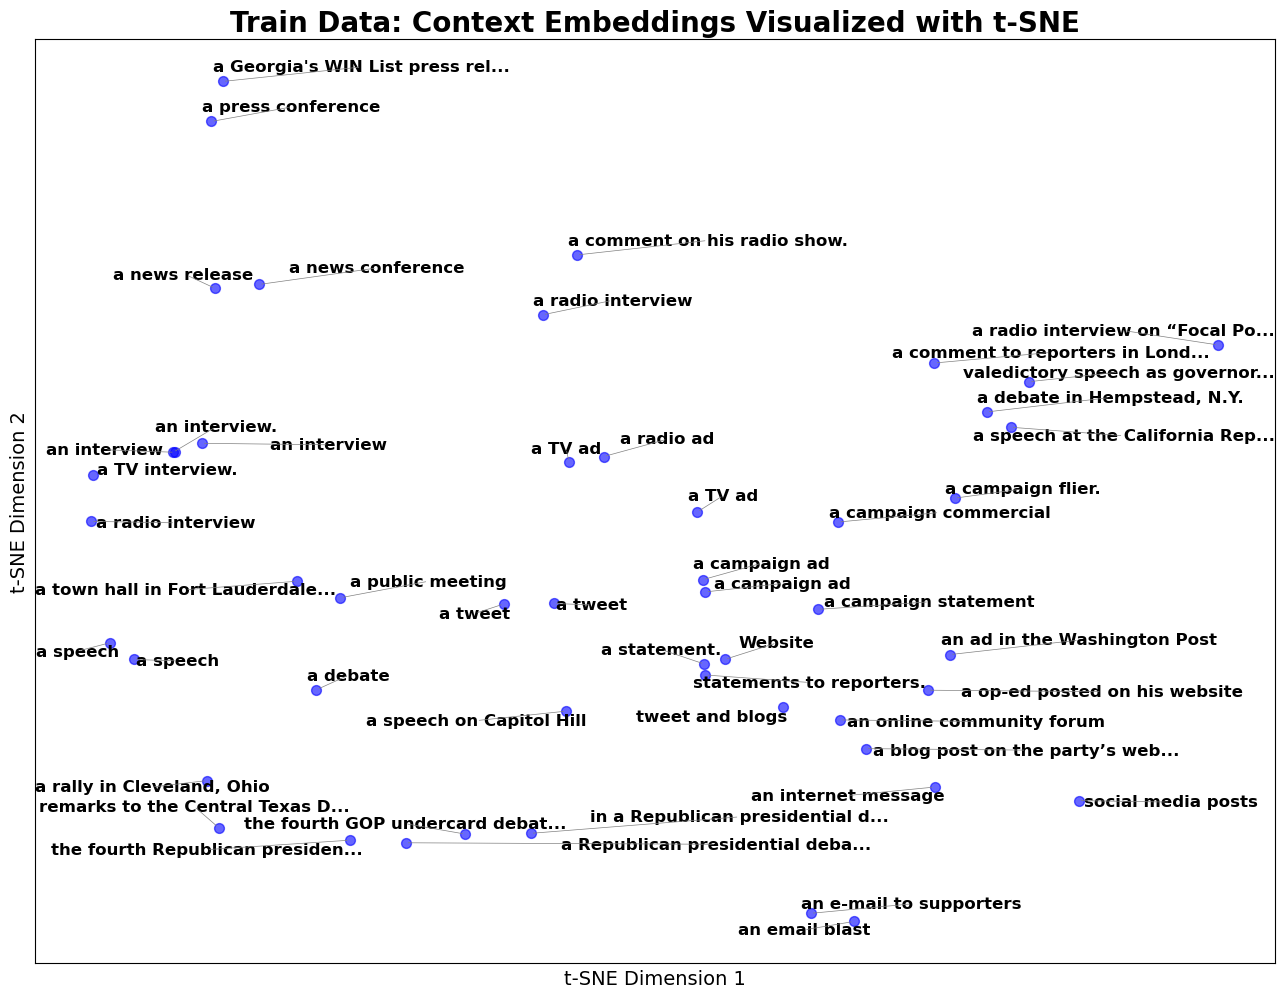

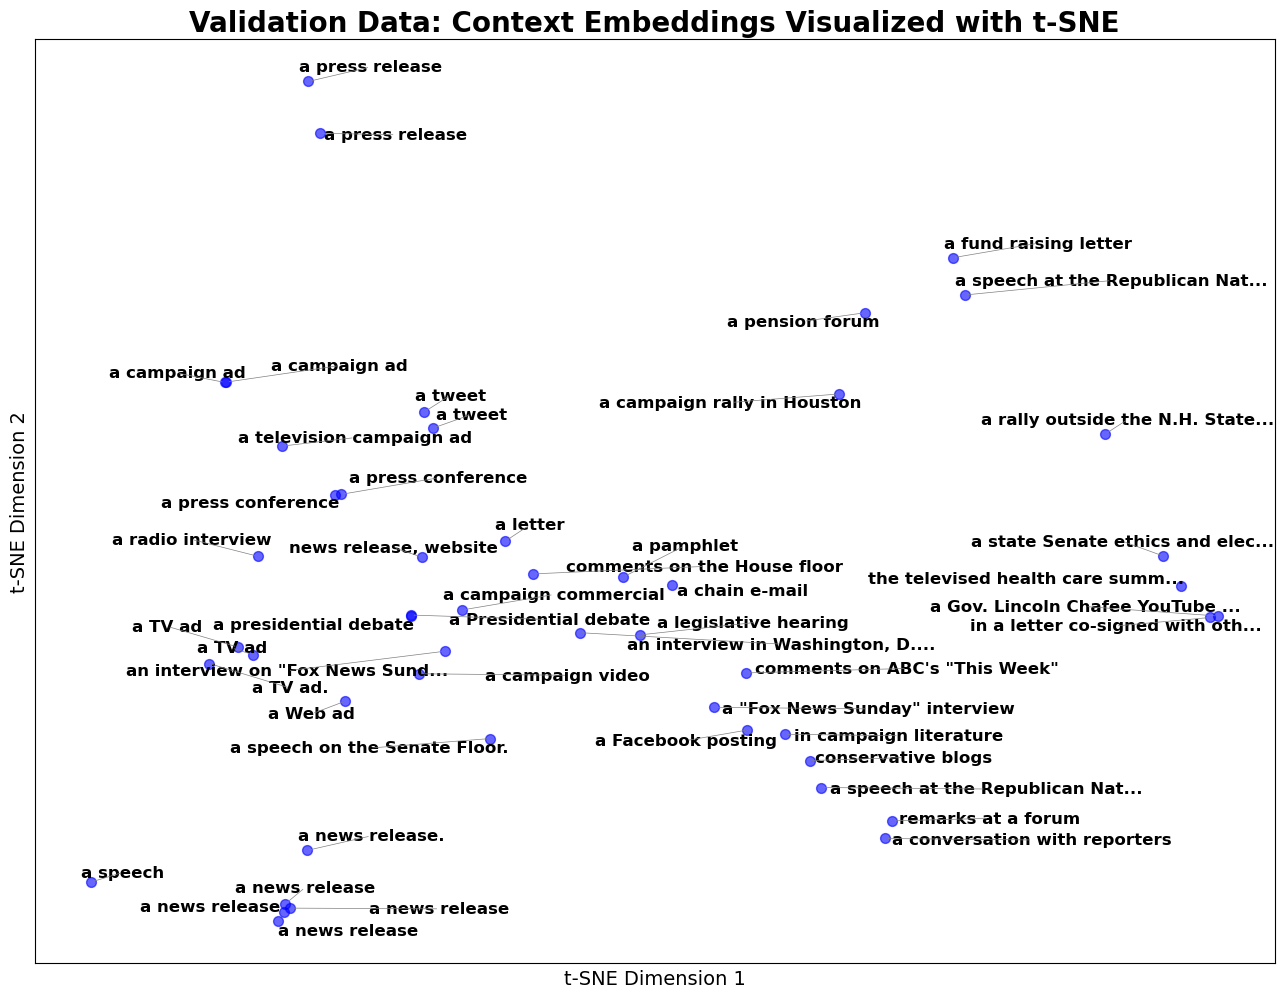

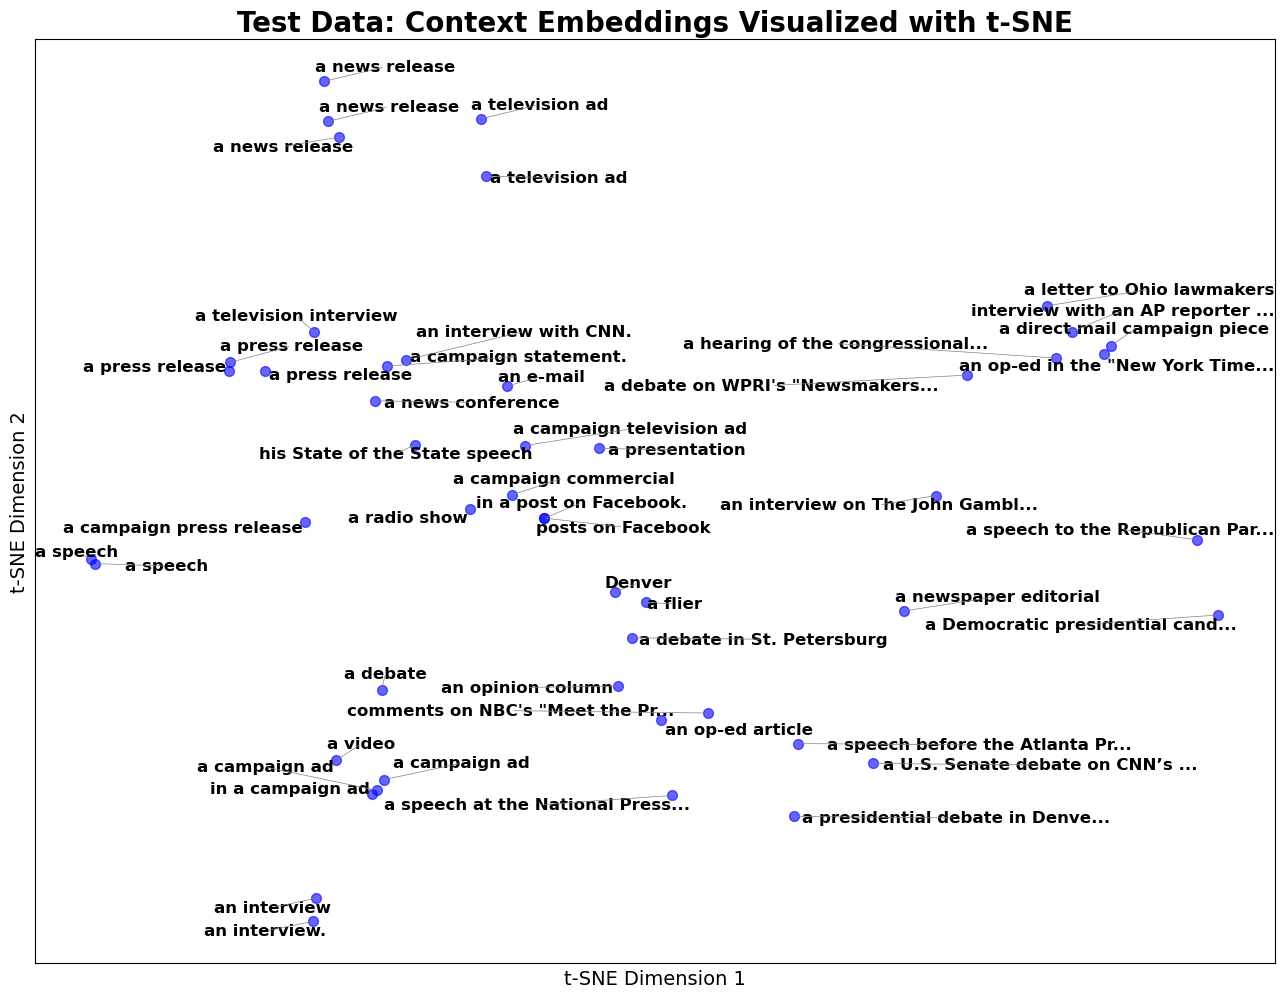

In [195]:
# use function to plot the t-SNE embeddings for the 'processed_context' column on train valid and test data
plot_tsne_embeddings(
    dataset=train_data, 
    embedding_column='processed_context_embedding', 
    label_column='context', 
    title='Train Data: Context Embeddings Visualized with t-SNE',
    max_label_length=30,
    x_label='t-SNE Dimension 1', 
    y_label='t-SNE Dimension 2'  
)

plot_tsne_embeddings(
    dataset=valid_data, 
    embedding_column='processed_context_embedding', 
    label_column='context', 
    title='Validation Data: Context Embeddings Visualized with t-SNE',
    max_label_length=30,
    x_label='t-SNE Dimension 1', 
    y_label='t-SNE Dimension 2'
)

plot_tsne_embeddings(
    dataset=test_data, 
    embedding_column='processed_context_embedding', 
    label_column='context', 
    title='Test Data: Context Embeddings Visualized with t-SNE',
    max_label_length=30,
    x_label='t-SNE Dimension 1', 
    y_label='t-SNE Dimension 2'
)

## Analyzing Correlations Between Embeddings and Label Encodings Using Cosine Similarity and Pearson Correlation

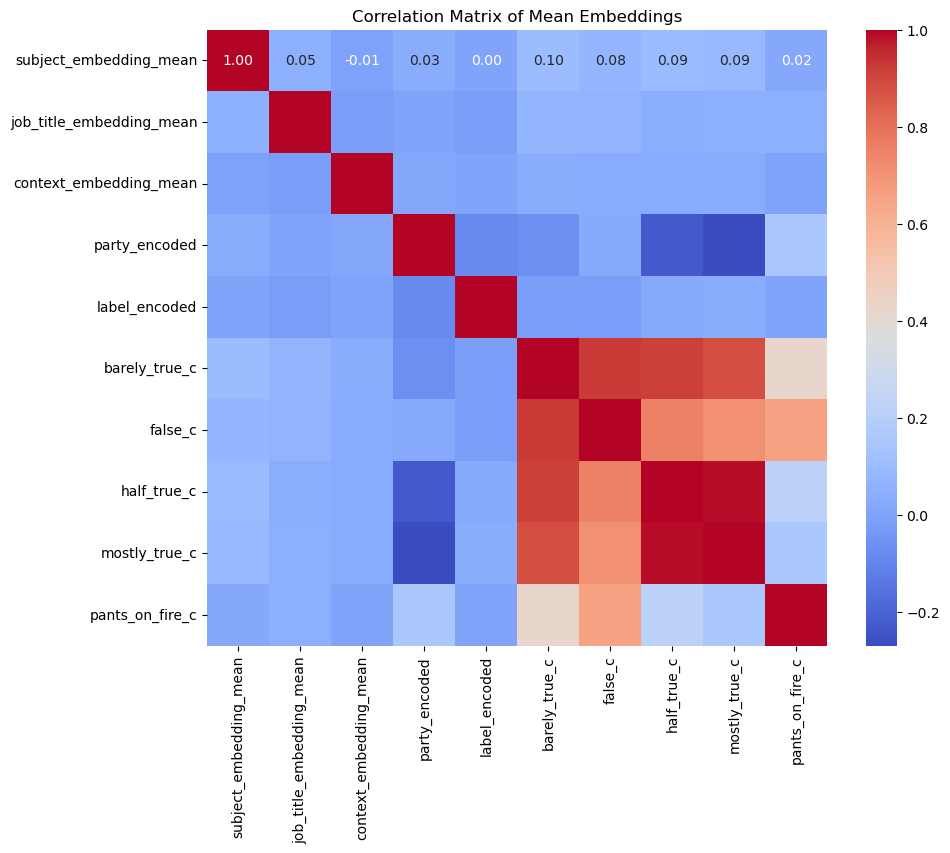

In [196]:
from numpy import dot
from numpy.linalg import norm
from scipy.stats import pearsonr

from sklearn.preprocessing import LabelEncoder

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

df = train_data.copy() # Use the train dataset for this analysis

# Fit and transform the 'label' column
df['label_encoded'] = label_encoder.fit_transform(df['label'])

# Select relevant columns for correlation
part_df = df[['subject_embedding_mean', 'job_title_embedding_mean', 'context_embedding_mean','party_encoded','label_encoded', 'barely_true_c', 'false_c', 'half_true_c', 'mostly_true_c', 'pants_on_fire_c']]
correlation_matrix = part_df.corr()

# Display the correlation matrix as a plot
plt.figure(figsize=(10, 8))
plt.title('Correlation Matrix of Mean Embeddings')
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.show()


In [197]:
part_df = df[['subject_embedding_mean', 'job_title_embedding_mean', 'context_embedding_mean','party_encoded','label_encoded']]
correlation_matrix = part_df.corr()
correlation_matrix

subject_embedding_mean  job_title_embedding_mean  \
subject_embedding_mean                  1.000000                  0.045272   
job_title_embedding_mean                0.045272                  1.000000   
context_embedding_mean                 -0.006642                 -0.017614   
party_encoded                           0.033835                  0.004851   
label_encoded                           0.004919                 -0.019426   

                          context_embedding_mean  party_encoded  label_encoded  
subject_embedding_mean                 -0.006642       0.033835       0.004919  
job_title_embedding_mean               -0.017614       0.004851      -0.019426  
context_embedding_mean                  1.000000       0.017733       0.003579  
party_encoded                           0.017733       1.000000      -0.082139  
label_encoded                           0.003579      -0.082139       1.000000

Build a basic ML model with the current features and evaluate its performance.

In [198]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

In [199]:
df_train = train_data.copy()
df_valid = valid_data.copy() 
df_test = test_data.copy() 

#get only numerical columns for model fitting
X_train = df_train.select_dtypes(include=['number']).copy()
X_valid = df_valid.select_dtypes(include=['number']).copy()
X_test = df_test.select_dtypes(include=['number']).copy()

X_train_combined = X_train.values
X_valid_combined = X_valid.values
X_test_combined = X_test.values

# Encode the labels for training
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(df_train['label'])
y_valid = label_encoder.fit_transform(df_valid['label'])
y_test = label_encoder.transform(df_test['label'])

# Create and fit the RandomForestClassifier model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_combined, y_train)

# Predict using the fitted model
all_predictions = model.predict(X_valid_combined)

# Display the predictions
predicted_labels = label_encoder.inverse_transform(all_predictions)
predicted_labels

array(['barely-true', 'pants-fire', 'half-true', ..., 'mostly-true',
       'false', 'mostly-true'], dtype=object)

In [200]:
# 1. Print the shapes of numeric features before embeddings are added
print("Shape of X_train (numeric features):", X_train.shape)
print("Shape of X_valid (numeric features):", X_valid.shape)
print("Shape of X_test (numeric features):", X_test.shape)

# 2. Print the numeric columns for train, valid, and test datasets to check for differences
print("Columns in X_train but not in X_valid:", set(X_train.columns) - set(X_valid.columns))
print("Columns in X_valid but not in X_train:", set(X_valid.columns) - set(X_train.columns))
print("Columns in X_train but not in X_test:", set(X_train.columns) - set(X_test.columns))
print("Columns in X_test but not in X_train:", set(X_test.columns) - set(X_train.columns))


Shape of X_train (numeric features): (10238, 9)
Shape of X_valid (numeric features): (1284, 9)
Shape of X_test (numeric features): (1267, 9)
Columns in X_train but not in X_valid: set()
Columns in X_valid but not in X_train: set()
Columns in X_train but not in X_test: set()
Columns in X_test but not in X_train: set()


In [44]:
from sklearn.metrics import accuracy_score

# Define the parameter grid for Random Forest
rf_param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [10, 15, 20, 25],
    'min_samples_split': [5, 10, 15],
    'min_samples_leaf': [5, 10, 15]
}

# Initialize lists to store results
best_params = None
best_valid_accuracy = 0
results = []

# Loop through all combinations of hyperparameters
for n_estimators in rf_param_grid['n_estimators']:
    for max_depth in rf_param_grid['max_depth']:
        for min_samples_split in rf_param_grid['min_samples_split']:
            for min_samples_leaf in rf_param_grid['min_samples_leaf']:
                
                # Initialize the Random Forest model with current hyperparameters
                rf = RandomForestClassifier(
                    n_estimators=n_estimators,
                    max_depth=max_depth,
                    min_samples_split=min_samples_split,
                    min_samples_leaf=min_samples_leaf,
                    random_state=42
                )
                
                # Train the model on training data
                rf.fit(X_train_combined, y_train)
                
                # Predict on validation data
                valid_predictions = rf.predict(X_valid_combined)
                
                # Calculate validation accuracy
                valid_accuracy = accuracy_score(y_valid, valid_predictions)
                
                # Store the hyperparameters and accuracy in the results
                results.append({
                    'n_estimators': n_estimators,
                    'max_depth': max_depth,
                    'min_samples_split': min_samples_split,
                    'min_samples_leaf': min_samples_leaf,
                    'validation_accuracy': valid_accuracy
                })
                
                # Update the best parameters if this is the best accuracy so far
                if valid_accuracy > best_valid_accuracy:
                    best_valid_accuracy = valid_accuracy
                    best_params = {
                        'n_estimators': n_estimators,
                        'max_depth': max_depth,
                        'min_samples_split': min_samples_split,
                        'min_samples_leaf': min_samples_leaf
                    }

# Print the best hyperparameters and their validation accuracy
print("Best Hyperparameters: ", best_params)
print("Best Validation Accuracy: ", best_valid_accuracy)

# Optionally, display all results for further analysis
import pandas as pd
results_df = pd.DataFrame(results)
display(results_df)



Best Hyperparameters:  {'n_estimators': 300, 'max_depth': 20, 'min_samples_split': 5, 'min_samples_leaf': 15}
Best Validation Accuracy:  0.4431464174454829


n_estimators  max_depth  min_samples_split  min_samples_leaf  \
0             100         10                  5                 5   
1             100         10                  5                10   
2             100         10                  5                15   
3             100         10                 10                 5   
4             100         10                 10                10   
..            ...        ...                ...               ...   
103           500         25                 10                10   
104           500         25                 10                15   
105           500         25                 15                 5   
106           500         25                 15                10   
107           500         25                 15                15   

     validation_accuracy  
0               0.426012  
1               0.441589  
2               0.441589  
3               0.426012  
4               0.441589  
..                   ...  
103             0.427570  
104             0.440810  
105             0.421340  
106             0.427570  
107             0.440810  

[108 rows x 5 columns]

In [201]:
# set the best hyperparameters we found in the previous step
n_estimators = 300
max_depth = 20
min_samples_split = 5
min_samples_leaf = 15


In [202]:
# save the results to a csv file results_df
results_df.to_csv('results_df.csv')
# make plots of the results
import seaborn as sns
import matplotlib.pyplot as plt

# Create a pairplot of the results
sns.pairplot(results_df, diag_kind='kde')
plt.show()


NameError: name 'results_df' is not defined

accuracy 0.45093457943925236
(row=expected, col=predicted)


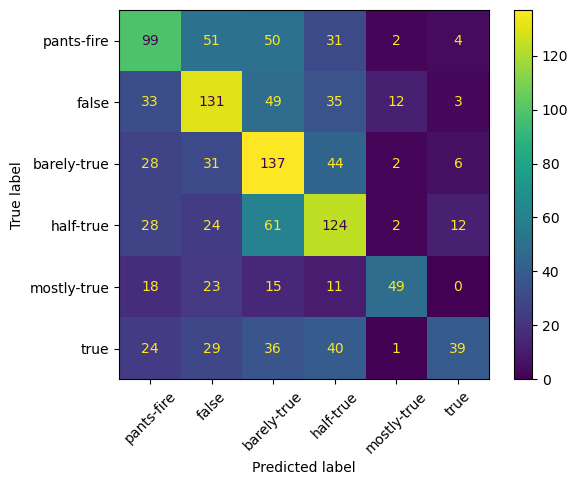

In [203]:
# Create and fit the RandomForestClassifier model with the best hyperparameters
model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, random_state=42)
#model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_combined, y_train)

# Predict using the fitted model
all_predictions = model.predict(X_valid_combined)

# Display the predictions
predicted_labels = label_encoder.inverse_transform(all_predictions)
predicted_labels

from sklearn.metrics import accuracy_score , confusion_matrix, ConfusionMatrixDisplay
my_labels =  ['pants-fire','false','barely-true','half-true','mostly-true','true']
print( 'accuracy', accuracy_score(valid_data['label'], predicted_labels))
cm =  confusion_matrix(valid_data['label'], predicted_labels, labels = my_labels)
ConfusionMatrixDisplay.from_predictions(y_true = valid_data['label'], y_pred = predicted_labels , display_labels = my_labels, xticks_rotation = 45)
print('(row=expected, col=predicted)')

accuracy 0.4198895027624309
(row=expected, col=predicted)


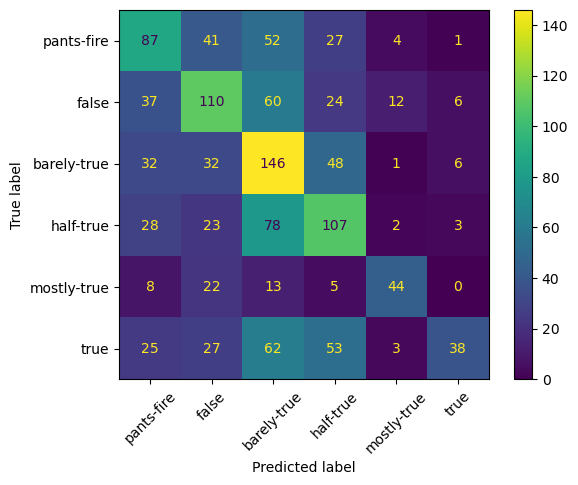

In [208]:
# check the test data on the current model
# Predict using the fitted model
all_predictions = model.predict(X_test_combined)
# Display the predictions
predicted_labels = label_encoder.inverse_transform(all_predictions)
predicted_labels

from sklearn.metrics import accuracy_score , confusion_matrix, ConfusionMatrixDisplay
my_labels =  ['pants-fire','false','barely-true','half-true','mostly-true','true']
print( 'accuracy', accuracy_score(test_data['label'], predicted_labels))
cm =  confusion_matrix(test_data['label'], predicted_labels, labels = my_labels)
ConfusionMatrixDisplay.from_predictions(y_true = test_data['label'], y_pred = predicted_labels , display_labels = my_labels, xticks_rotation = 45)
print('(row=expected, col=predicted)')



## Error Analysis


In [215]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report

# y_true: Actual labels from the test data
y_true = test_data['label']

# y_pred: Predicted labels from the model
y_pred = predicted_labels

# Define your class labels
class_labels = ['pants-fire', 'false', 'barely-true', 'half-true', 'mostly-true', 'true']

# Calculate and print metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro', labels=class_labels)
recall = recall_score(y_true, y_pred, average='macro', labels=class_labels)
f1 = f1_score(y_true, y_pred, average='macro', labels=class_labels)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Alternatively, get a full classification report for each class
report = classification_report(y_true, y_pred, target_names=class_labels)
print("\nClassification Report:\n", report)


Accuracy: 0.4199
Precision: 0.4939
Recall: 0.4180
F1-Score: 0.4241

Classification Report:
               precision    recall  f1-score   support

  pants-fire       0.40      0.41      0.41       212
       false       0.43      0.44      0.44       249
 barely-true       0.36      0.55      0.43       265
   half-true       0.41      0.44      0.42       241
 mostly-true       0.67      0.48      0.56        92
        true       0.70      0.18      0.29       208

    accuracy                           0.42      1267
   macro avg       0.49      0.42      0.42      1267
weighted avg       0.47      0.42      0.41      1267



# Adding features

## Adding lenght features

In [216]:
# Define the function that applies the transformations
def add_lenght_features(data):
    # Add statement_id as the index
    data['statement_id'] = data.index
    
    # Calculate the length of the statement by words
    data['length_statement_words'] = data['statement'].apply(lambda x: len(x.split()))
    
    # Calculate the length of the statement by letters
    data['length_statement_letters'] = data['statement'].apply(lambda x: len(x.replace(" ", "")))
    
    # Calculate the average word length per statement
    data['avg_word_length_per_statement'] = data['length_statement_letters'] / data['length_statement_words']
    
    # Move the 'statement_id' column to the index
    data = data.set_index('statement_id')
    
    return data

# Apply the function to each dataset
train_data = add_lenght_features(train_data)
valid_data = add_lenght_features(valid_data)
test_data = add_lenght_features(test_data)


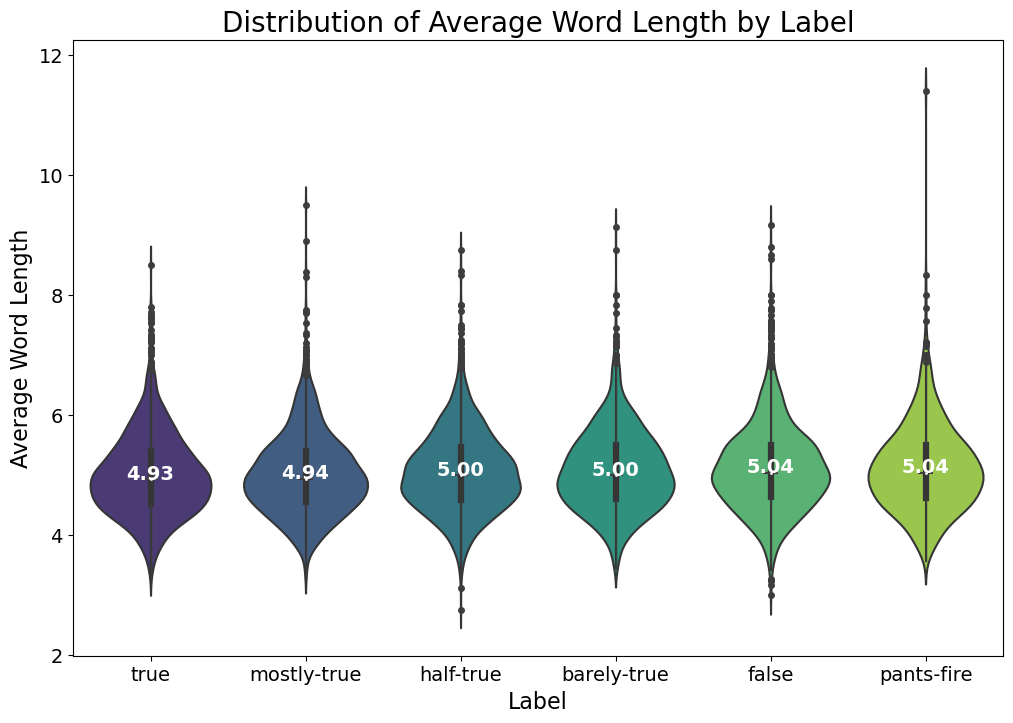

In [218]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define the custom label order
label_order = ['true', 'mostly-true', 'half-true', 'barely-true', 'false', 'pants-fire']

# Create the figure and plot the violin plot
plt.figure(figsize=(12, 8))

# Violin plot with 'viridis' palette and custom label order
sns.violinplot(data=train_data, x='label', y='avg_word_length_per_statement', palette='viridis', inner='box', order=label_order)

# Add box plot over the violin plot with custom label order
sns.boxplot(data=train_data, x='label', y='avg_word_length_per_statement', 
            width=0.1, showmeans=False, meanline=False, 
            boxprops={'facecolor':'none'}, showcaps=False, whiskerprops={'linewidth':1}, 
            flierprops={'marker':'o', 'markersize':4}, order=label_order)

# Calculate medians and annotate them inside the boxes (in the custom order)
medians = train_data.groupby(['label'])['avg_word_length_per_statement'].median().reindex(label_order).values
for xtick, median in enumerate(medians):
    plt.text(xtick, median, f'{median:.2f}', 
             horizontalalignment='center', size=14, color='white', weight='semibold')  # Increase annotation font size

# Set the plot's title and labels with increased font sizes
plt.title('Distribution of Average Word Length by Label', fontsize=20)
plt.xlabel('Label', fontsize=16)
plt.ylabel('Average Word Length', fontsize=16)

# Set the font size for the tick labels
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Display the plot
plt.show()

## Add credibility score as a feature

In [220]:
print(train_data.columns)


Index(['label', 'statement', 'subject', 'speaker', 'job_title', 'state',
       'party', 'barely_true_c', 'false_c', 'half_true_c', 'mostly_true_c',
       'pants_on_fire_c', 'context', 'processed_text', 'processed_job_title',
       'processed_subject', 'processed_context', 'processed_subject_embedding',
       'subject_embedding_mean', 'processed_job_title_embedding',
       'job_title_embedding_mean', 'party_encoded',
       'processed_context_embedding', 'context_embedding_mean',
       'length_statement_words', 'length_statement_letters',
       'avg_word_length_per_statement'],
      dtype='object')


In [221]:
import pandas as pd
import numpy as np

# Define penalties for each count column
penalty_weights = {
    'pants_on_fire_c': 40,  # Largest penalty
    'false_c': 30,          # Large penalty
    'barely_true_c': 20,     # Medium penalty
    'half_true_c': 10,       # Small penalty
    'mostly_true_c': 5       # Smallest penalty
}

train_data_temp = train_data.copy() # Use the train dataset for this analysis
valid_data_temp = valid_data.copy()
test_data_temp = test_data.copy()

# Step 1: Calculate the total penalty for each speaker
# Multiply each count column by its corresponding penalty weight

train_data_temp['total_penalty'] = (
    train_data['pants_on_fire_c'] * penalty_weights['pants_on_fire_c'] +
    train_data['false_c'] * penalty_weights['false_c'] +
    train_data['barely_true_c'] * penalty_weights['barely_true_c'] +
    train_data['half_true_c'] * penalty_weights['half_true_c'] +
    train_data['mostly_true_c'] * penalty_weights['mostly_true_c']
)

# Step 2: Calculate the total number of statements (sum of all counts) for each speaker
train_data_temp['total_statements'] = (
    train_data['pants_on_fire_c'] +
    train_data['false_c'] +
    train_data['barely_true_c'] +
    train_data['half_true_c'] +
    train_data['mostly_true_c']
)

# Step 3: Calculate the credibility score
# Start with 100 and subtract the weighted penalty normalized by the total number of statements
train_data['credibility_score'] = 100 - (train_data_temp['total_penalty'] / train_data_temp['total_statements'])
train_data['credibility_score'].fillna(100, inplace=True)  # If no statements, credibility is 100

# Step 4: Repeat the same process for the validation and test datasets
valid_data_temp['total_penalty'] = (
    valid_data['pants_on_fire_c'] * penalty_weights['pants_on_fire_c'] +
    valid_data['false_c'] * penalty_weights['false_c'] +
    valid_data['barely_true_c'] * penalty_weights['barely_true_c'] +
    valid_data['half_true_c'] * penalty_weights['half_true_c'] +
    valid_data['mostly_true_c'] * penalty_weights['mostly_true_c']
)

valid_data_temp['total_statements'] = (
    valid_data['pants_on_fire_c'] +
    valid_data['false_c'] +
    valid_data['barely_true_c'] +
    valid_data['half_true_c'] +
    valid_data['mostly_true_c']
)

valid_data['credibility_score'] = 100 - (valid_data_temp['total_penalty'] / valid_data_temp['total_statements'])
valid_data['credibility_score'].fillna(100, inplace=True)

# For the test data
test_data_temp['total_penalty'] = (
    test_data['pants_on_fire_c'] * penalty_weights['pants_on_fire_c'] +
    test_data['false_c'] * penalty_weights['false_c'] +
    test_data['barely_true_c'] * penalty_weights['barely_true_c'] +
    test_data['half_true_c'] * penalty_weights['half_true_c'] +
    test_data['mostly_true_c'] * penalty_weights['mostly_true_c']
)

test_data_temp['total_statements'] = (
    test_data['pants_on_fire_c'] +
    test_data['false_c'] +
    test_data['barely_true_c'] +
    test_data['half_true_c'] +
    test_data['mostly_true_c']
)

test_data['credibility_score'] = 100 - (test_data_temp['total_penalty'] / test_data_temp['total_statements'])
test_data['credibility_score'].fillna(100, inplace=True)

# Step 5: Verify the new credibility score feature
display(train_data[['speaker', 'credibility_score']].head())
display(valid_data[['speaker', 'credibility_score']].head())
display(test_data[['speaker', 'credibility_score']].head())


speaker  credibility_score
statement_id                                   
0               dwayne-bohac          70.000000
1             scott-surovell          92.500000
2               barack-obama          86.670190
3               blog-posting          67.628205
4              charlie-crist          85.461538

speaker  credibility_score
statement_id                                    
0              vicky-hartzler           85.00000
1                 chain-email           66.19186
2             earl-blumenauer           85.00000
3             jim-francesconi           85.00000
4                barack-obama           86.67019

speaker  credibility_score
statement_id                                                     
0                                   rick-perry          80.734266
1                            katrina-shankland          76.666667
2                                 donald-trump          76.027607
3                                rob-cornilles          82.142857
4             state-democratic-party-wisconsin          73.043478

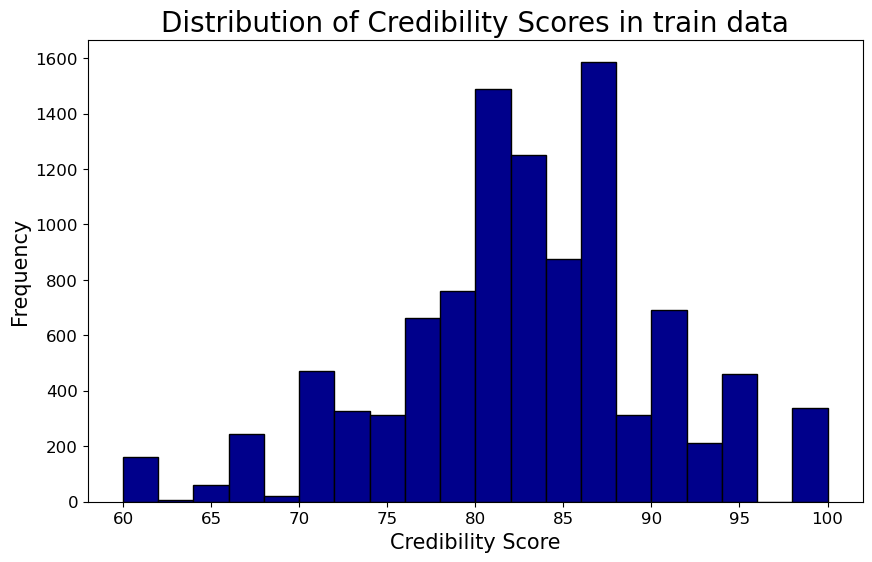

In [222]:
# credibility score distribution for train data
plt.figure(figsize=(10, 6))
plt.hist(train_data['credibility_score'], bins=20, color='darkblue', edgecolor='black')
plt.title('Distribution of Credibility Scores in train data', size=20)
plt.xlabel('Credibility Score', size=15)
plt.ylabel('Frequency', size=15)
plt.xticks(size=12)
plt.yticks(size=12)

plt.show()

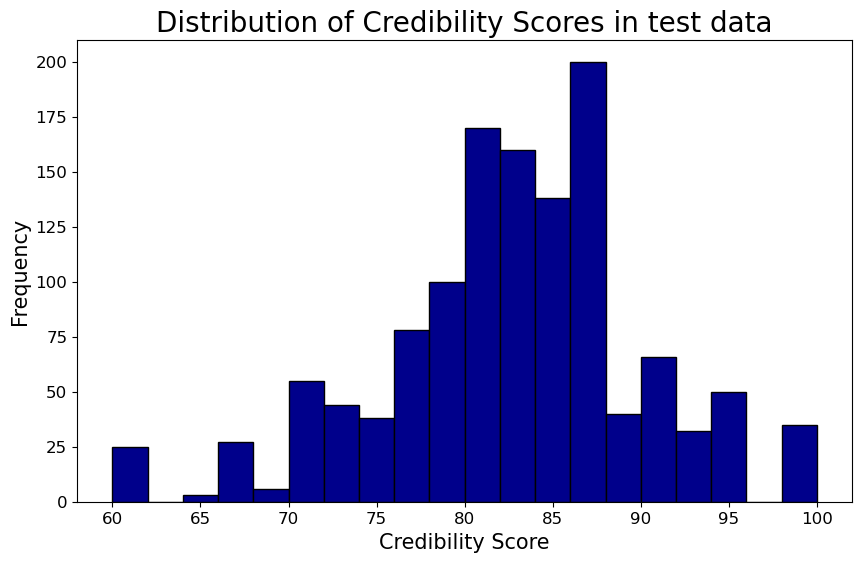

In [224]:
#credibility score distribution for test data
plt.figure(figsize=(10, 6))
plt.hist(test_data['credibility_score'], bins=20, color='darkblue', edgecolor='black')
plt.title('Distribution of Credibility Scores in test data', size=20)
plt.xlabel('Credibility Score', size=15)
plt.ylabel('Frequency', size=15)
plt.xticks(size=12)
plt.yticks(size=12)

plt.show()

In [226]:
train_data

label                                          statement  \
statement_id                                                                   
0                   false  Says the Annies List political group supports ...   
1               half-true  When did the decline of coal start? It started...   
2             mostly-true  Hillary Clinton agrees with John McCain "by vo...   
3                   false  Health care reform legislation is likely to ma...   
4               half-true  The economic turnaround started at the end of ...   
...                   ...                                                ...   
10233         mostly-true  There are a larger number of shark attacks in ...   
10234         mostly-true  Democrats have now become the party of the [At...   
10235           half-true  Says an alternative to Social Security that op...   
10236               false  On lifting the U.S. Cuban embargo and allowing...   
10237          pants-fire  The Department of Veterans Affairs has a manua...   

                                         subject         speaker  \
statement_id                                                       
0                                       abortion    dwayne-bohac   
1             energy,history,job-accomplishments  scott-surovell   
2                                 foreign-policy    barack-obama   
3                                    health-care    blog-posting   
4                                   economy,jobs   charlie-crist   
...                                          ...             ...   
10233                          animals,elections    aclu-florida   
10234                                  elections     alan-powell   
10235                 retirement,social-security     herman-cain   
10236                     florida,foreign-policy     jeff-greene   
10237                       health-care,veterans  michael-steele   

                                                  job_title     state  \
statement_id                                                            
0                                      State representative     Texas   
1                                            State delegate  Virginia   
2                                                 President  Illinois   
3                                                       NaN       NaN   
4                                                       NaN   Florida   
...                                                     ...       ...   
10233                                                   NaN   Florida   
10234                                                   NaN   Georgia   
10235                                                   NaN   Georgia   
10236                                                   NaN   Florida   
10237         chairman of the Republican National Committee  Maryland   

                   party  barely_true_c  false_c  half_true_c  ...  \
statement_id                                                   ...   
0             republican            0.0      1.0          0.0  ...   
1               democrat            0.0      0.0          1.0  ...   
2               democrat           70.0     71.0        160.0  ...   
3                   none            7.0     19.0          3.0  ...   
4               democrat           15.0      9.0         20.0  ...   
...                  ...            ...      ...          ...  ...   
10233               none            0.0      1.0          1.0  ...   
10234         republican            0.0      0.0          0.0  ...   
10235         republican            4.0     11.0          5.0  ...   
10236           democrat            3.0      1.0          3.0  ...   
10237         republican            0.0      1.0          1.0  ...   

              subject_embedding_mean  \
statement_id                           
0                          -0.001117   
1                          -0.001864   
2                          -0.001106   
3                          -0.000

In [227]:
# print the speakers with the highest true label counts
train_data[train_data['label'] == 'true']['speaker'].value_counts().head(10)


speaker
barack-obama       103
hillary-clinton     60
mitt-romney         30
john-mccain         29
rick-perry          21
scott-walker        21
chris-christie      18
marco-rubio         16
bernie-s            14
rick-scott          13
Name: count, dtype: int64

In [229]:
# print the speakers with the highest credibility score
train_data[['speaker', 'credibility_score']].sort_values(by='credibility_score', ascending=False).head(10)


speaker  credibility_score
statement_id                                       
9317                 john-scocos              100.0
3728                 jim-gilmore              100.0
8798             melissa-johnson              100.0
5681           james-skeffington              100.0
8808                 john-dennis              100.0
5699          yvette-mcgee-brown              100.0
2886                  ryan-lizza              100.0
1870             russell-mcmurry              100.0
2891                ronda-storms              100.0
9369                  dave-joyce              100.0

## Adding TF-IDF feature based on statement text

In [230]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder

# Function to fit the model on each dataset and add the 'tfidf' column
def process_data_with_new_model(data, preprocess_text):
    # Step 1: Fit CountVectorizer and TfidfTransformer on the dataset
    bow_transformer = CountVectorizer(analyzer=preprocess_text).fit(data['statement'])
    statements_bow = bow_transformer.transform(data['statement'])
    
    tfidf_transformer = TfidfTransformer().fit(statements_bow)
    statements_tfidf = tfidf_transformer.transform(statements_bow)

    # Step 2: Train the model on the dataset
    model = MultinomialNB().fit(statements_tfidf, data['label'])

    # Step 3: Predict using the trained model
    predictions = model.predict(statements_tfidf)

    # Step 4: Fit the LabelEncoder on the predictions
    label_encoder = LabelEncoder()
    encoded_predictions = label_encoder.fit_transform(predictions)
    #print(list(label_encoder.inverse_transform([1,2,3,4,5])))

    # Step 5: Add the encoded predictions as a new column
    data['tfidf'] = encoded_predictions
    
    return data


train_data = process_data_with_new_model(train_data, preprocess_text)

valid_data = process_data_with_new_model(valid_data, preprocess_text)

test_data = process_data_with_new_model(test_data, preprocess_text)

In [232]:
# Display the first few rows of the train dataset to verify the results
display(train_data[['statement', 'tfidf']].head())

# Display the first few rows of the valid dataset to verify the results
display(valid_data[['statement', 'tfidf']].head())

# Display the first few rows of the test dataset to verify the results
display(test_data[['statement', 'tfidf']].head())

statement  tfidf
statement_id                                                          
0             Says the Annies List political group supports ...      1
1             When did the decline of coal start? It started...      2
2             Hillary Clinton agrees with John McCain "by vo...      2
3             Health care reform legislation is likely to ma...      1
4             The economic turnaround started at the end of ...      2

statement  tfidf
statement_id                                                          
0             We have less Americans working now than in the...      3
1             When Obama was sworn into office, he DID NOT u...      4
2             Says Having organizations parading as being so...      1
3                Says nearly half of Oregons children are poor.      2
4             On attacks by Republicans that various program...      2

statement  tfidf
statement_id                                                          
0             Building a wall on the U.S.-Mexico border will...      1
1             Wisconsin is on pace to double the number of l...      1
2             Says John McCain has done nothing to help the ...      1
3             Suzanne Bonamici supports a plan that will cut...      2
4             When asked by a reporter whether hes at the ce...      1

In [233]:
labels_encoded = label_encoder.fit_transform(train_data['label'])
list(label_encoder.inverse_transform([0,1,2,3,4,5]))

['barely-true', 'false', 'half-true', 'mostly-true', 'pants-fire', 'true']

accuracy 0.5870287165462005
(row=expected, col=predicted)


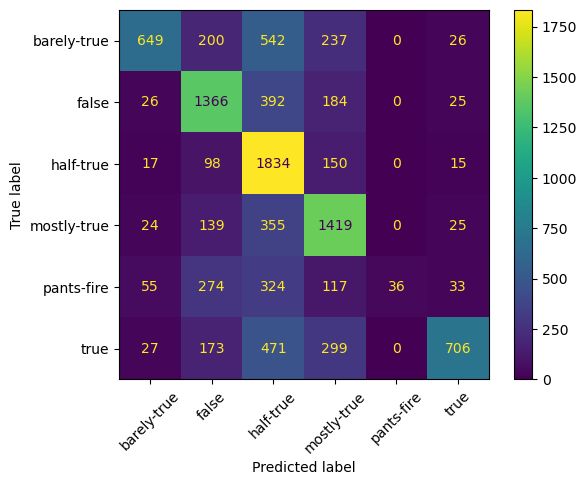

In [234]:
#draw confusion matrix of train data
order = [4,1,2,3,5]
print( 'accuracy', accuracy_score(labels_encoded, train_data[['tfidf']]))
#cm =  confusion_matrix(labels_encoded, train_data[['tfidf']], labels = my_labels)
ConfusionMatrixDisplay.from_predictions(y_true = labels_encoded, y_pred = train_data[['tfidf']] , display_labels = ['barely-true','false', 'half-true', 'mostly-true', 'pants-fire', 'true'], xticks_rotation = 45)
print( '(row=expected, col=predicted)')

# Topic Modeling with LDA
This section handles topic modeling using LDA (Latent Dirichlet Allocation).

num_topics  coherence_score
0           4         0.358778
1           6         0.330446
2           8         0.338724
3          10         0.330016
4          12         0.339368
5          14         0.366615
6          16         0.366186
7          18         0.348110
8          20         0.345928

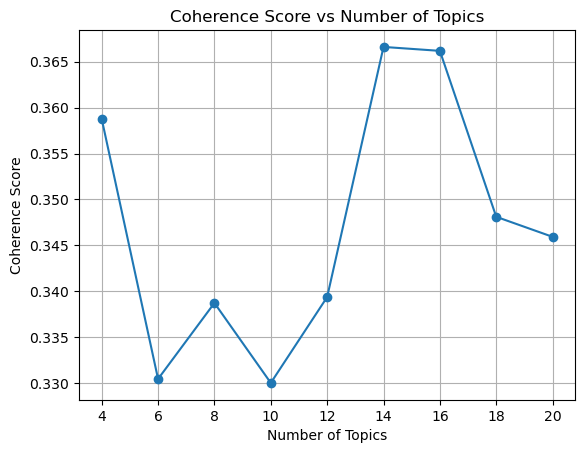

In [235]:
from gensim.models import CoherenceModel
from gensim import corpora
from gensim.models.ldamodel import LdaModel
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Set seed for reproducibility
np.random.seed(42)

def evaluate_lda_with_coherence(train_data, num_topics_range, passes=20, random_state=42):
    """
    Trains multiple LDA models with different numbers of topics and evaluates them using the coherence score.

    Parameters:
    - train_data: DataFrame containing 'processed_text'
    - num_topics_range: List of numbers of topics to evaluate
    - passes: Number of passes for LDA training (default is 20)
    - random_state: Seed for reproducibility (default is 42)

    Returns:
    - DataFrame containing coherence scores and number of topics
    """
    # Create a dictionary and corpus for the LDA model
    dictionary = corpora.Dictionary(train_data['processed_text'])
    corpus = [dictionary.doc2bow(text) for text in train_data['processed_text']]

    results = []

    for num_topics in num_topics_range:
        # Train the LDA model with a fixed random state
        lda_model = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=passes, random_state=random_state)

        # Evaluate the model using coherence score
        coherence_model = CoherenceModel(model=lda_model, texts=train_data['processed_text'], dictionary=dictionary, coherence='c_v')
        coherence_score = coherence_model.get_coherence()

        # Store results
        results.append({'num_topics': num_topics, 'coherence_score': coherence_score})

    # Convert results to DataFrame for easy visualization
    return pd.DataFrame(results)

# Define the range of topics to try
num_topics_range = [4, 6, 8, 10, 12, 14, 16, 18, 20]

# Evaluate LDA models
lda_evaluation_results = evaluate_lda_with_coherence(train_data, num_topics_range)

# Display the coherence scores
display(lda_evaluation_results)

# Plot the coherence scores for easier interpretation
plt.plot(lda_evaluation_results['num_topics'], lda_evaluation_results['coherence_score'], marker='o')
plt.title('Coherence Score vs Number of Topics')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.grid(True)
plt.show()


In [236]:
# choose the best number of topics 
from gensim.models import CoherenceModel
from gensim import corpora
from gensim.models.ldamodel import LdaModel
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def runLDA(data, num_topics = 16, passes=20, random_state=42):
    """
    Trains an LDA model on the given data and returns the trained model.

    Parameters:
    - data: DataFrame containing 'processed_text'
    - num_topics: Number of topics for the LDA model
    - passes: Number of passes for LDA training (default is 20)
    - random_state: Seed for reproducibility (default is 42)

    Returns:
    - Trained LDA model
    """
    # Create a dictionary and corpus for the LDA model
    dictionary = corpora.Dictionary(data['processed_text'])
    corpus = [dictionary.doc2bow(text) for text in data['processed_text']]

    # Train the LDA model with a fixed random state
    lda_model = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=passes, random_state=random_state)

    return lda_model, dictionary, corpus

# run the LDA model on the train data, valid data and test data

train_lda_model, train_dict, train_corpus = runLDA(train_data)
valid_lda_model, valid_dict, valid_corpus = runLDA(valid_data)
test_lda_model, test_dict, test_corpus = runLDA(test_data)


In [237]:
!pip install pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis
import webbrowser


# Prepare the visualization
lda_display = gensimvis.prepare(train_lda_model, train_corpus, train_dict)
pyLDAvis.save_html(lda_display, 'train_lda_visualization.html')
webbrowser.open('train_lda_visualization.html')

# Prepare the visualization for the valid data
lda_display = gensimvis.prepare(valid_lda_model, valid_corpus, valid_dict)
pyLDAvis.save_html(lda_display, 'valid_lda_visualization.html')
webbrowser.open('valid_lda_visualization.html')

# Prepare the visualization for the test data
lda_display = gensimvis.prepare(test_lda_model, test_corpus, test_dict)
pyLDAvis.save_html(lda_display, 'test_lda_visualization.html')
webbrowser.open('test_lda_visualization.html')



True

label           barely-true  false  half-true  mostly-true  pants-fire  true
dominant_topic                                                              
0                       120    128        191          177          48   166
1                        57     64         64           41          30    43
2                        56     86         86           83          27    64
3                        97     96        108          108          31    88
4                        62     72         74           80          36    74
5                        91    107         93           65          50    60
6                        74    114         88           78          39    81
7                       111    144        210          241          47   172
8                        76    107        106           95          42    92
9                       381    412        454          375         138   290
10                       43     57         45           47          38    36

<Axes: xlabel='dominant_topic'>

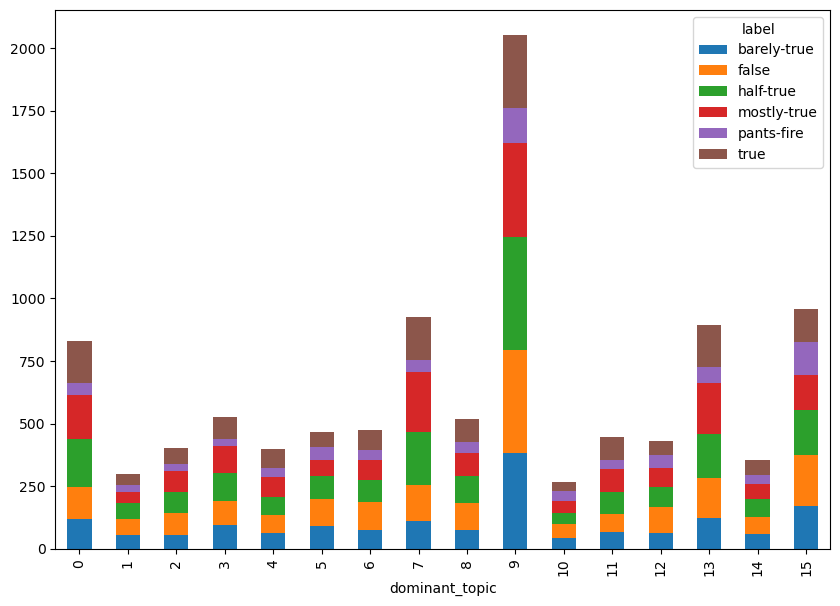

In [238]:

# Get the topic distribution for each document
topic_distributions = train_lda_model.get_document_topics(train_corpus, minimum_probability=0)

# Extract the dominant topic for each document
dominant_topics = []
for dist in topic_distributions:
    # dist is a list of (topic_id, probability) tuples
    dominant_topic = max(dist, key=lambda x: x[1])[0]  # Get the topic with the highest probability
    dominant_topics.append(dominant_topic)

# Add the dominant topic to the DataFrame
train_data['dominant_topic'] = dominant_topics

# Group by topic and label to see the distribution of labels within each topic
label_distribution_by_topic = train_data.groupby(['dominant_topic', 'label']).size().unstack(fill_value=0)

# Display the distribution
print(label_distribution_by_topic)

# Optionally, you can visualize the distribution using a bar chart
label_distribution_by_topic.plot(kind='bar', stacked=True, figsize=(10, 7))

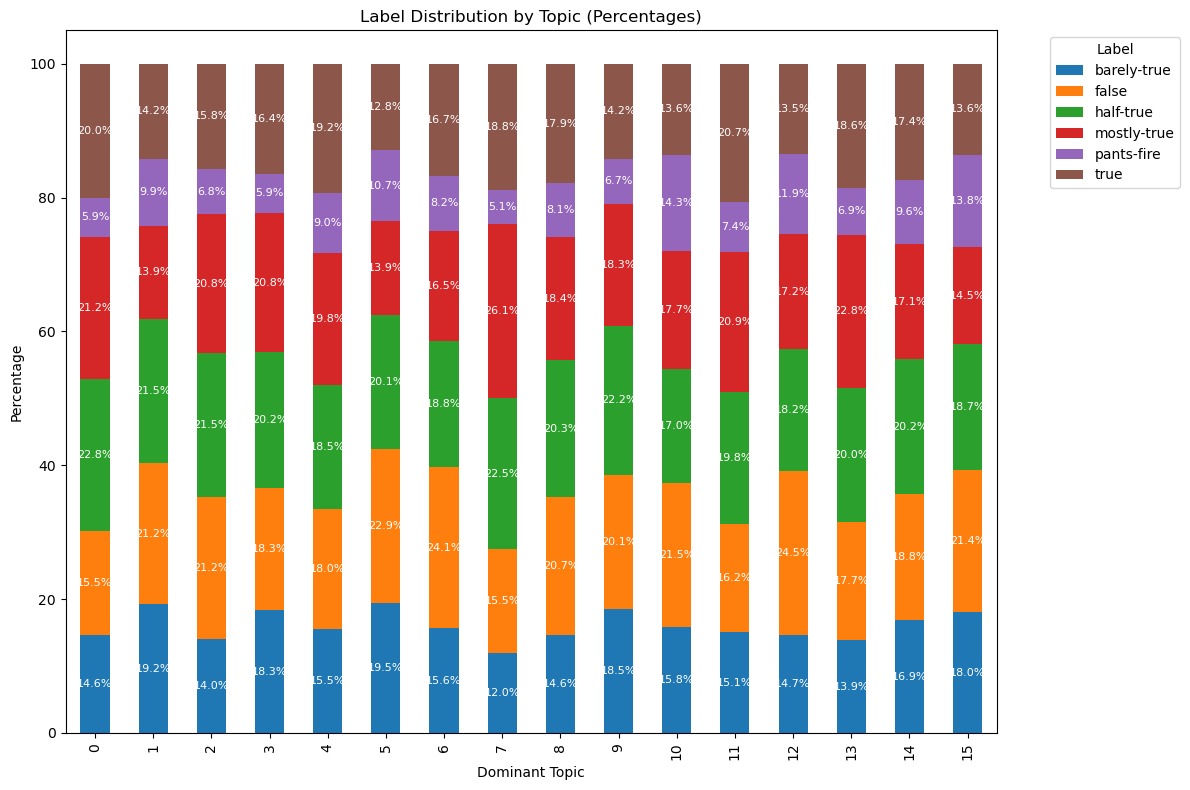

In [239]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Get the topic distribution for each document
topic_distributions = train_lda_model.get_document_topics(train_corpus, minimum_probability=0)

# Extract the dominant topic for each document
dominant_topics = []
for dist in topic_distributions:
    # dist is a list of (topic_id, probability) tuples
    dominant_topic = max(dist, key=lambda x: x[1])[0]  # Get the topic with the highest probability
    dominant_topics.append(dominant_topic)

# Add the dominant topic to the DataFrame
train_data['dominant_topic'] = dominant_topics

# Group by topic and label to see the distribution of labels within each topic
label_distribution_by_topic = train_data.groupby(['dominant_topic', 'label']).size().unstack(fill_value=0)

# Calculate the percentage distribution within each topic
label_distribution_percentages = label_distribution_by_topic.div(label_distribution_by_topic.sum(axis=1), axis=0) * 100

# Plot the percentage distribution
fig, ax = plt.subplots(figsize=(12, 8))
label_distribution_percentages.plot(kind='bar', stacked=True, ax=ax)

# Add percentages on the bars
for p in ax.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    if height > 0:  # Only label non-zero segments
        ax.text(x + width/2, y + height/2, f'{height:.1f}%', ha='center', va='center', fontsize=8, color='white')

# Move the legend outside the plot
ax.legend(title='Label', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title('Label Distribution by Topic (Percentages)')
plt.xlabel('Dominant Topic')
plt.ylabel('Percentage')
plt.tight_layout()
plt.show()

In [240]:
# add the dominant topic to each sample of the train data
import pandas as pd
import numpy as np

# Define a function to add the dominant topic to the dataset
def add_dominant_topic(lda_model, corpus, data):
    # Get the topic distribution for each document
    topic_distributions = lda_model.get_document_topics(corpus, minimum_probability=0)

    # Extract the dominant topic for each document
    dominant_topics = []
    for dist in topic_distributions:
        dominant_topic = max(dist, key=lambda x: x[1])[0]  # Get the topic with the highest probability
        dominant_topics.append(dominant_topic)

    # Add the dominant topic to the DataFrame
    data['dominant_topic'] = dominant_topics
    
    return data


# Add the dominant topic to each dataset
train_data = add_dominant_topic(train_lda_model, train_corpus, train_data)
valid_data = add_dominant_topic(valid_lda_model, valid_corpus, valid_data)
test_data = add_dominant_topic(test_lda_model, test_corpus, test_data)

# Display the first few rows of each updated DataFrame to verify the result
print(train_data.head())
print(valid_data.head())
print(test_data.head())


                    label                                          statement  \
statement_id                                                                   
0                   false  Says the Annies List political group supports ...   
1               half-true  When did the decline of coal start? It started...   
2             mostly-true  Hillary Clinton agrees with John McCain "by vo...   
3                   false  Health care reform legislation is likely to ma...   
4               half-true  The economic turnaround started at the end of ...   

                                         subject         speaker  \
statement_id                                                       
0                                       abortion    dwayne-bohac   
1             energy,history,job-accomplishments  scott-surovell   
2                                 foreign-policy    barack-obama   
3                                    health-care    blog-posting   
4                              

## Model with new features

In [241]:
df_train = train_data.copy()
df_valid = valid_data.copy() 
df_test = test_data.copy() 

#get only numerical columns for model fitting
X_train = df_train.select_dtypes(include=['number']).copy()
X_valid = df_valid.select_dtypes(include=['number']).copy()
X_test = df_test.select_dtypes(include=['number']).copy()

X_train_combined = X_train.values
X_valid_combined = X_valid.values
X_test_combined = X_test.values

# Encode the labels for training
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(df_train['label'])
y_valid = label_encoder.fit_transform(df_valid['label'])
y_test = label_encoder.transform(df_test['label'])


c:\Users\sigal\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\sigal\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\sigal\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\sigal\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not 

In [242]:
X_train

barely_true_c  false_c  half_true_c  mostly_true_c  \
statement_id                                                       
0                       0.0      1.0          0.0            0.0   
1                       0.0      0.0          1.0            1.0   
2                      70.0     71.0        160.0          163.0   
3                       7.0     19.0          3.0            5.0   
4                      15.0      9.0         20.0           19.0   
...                     ...      ...          ...            ...   
10233                   0.0      1.0          1.0            1.0   
10234                   0.0      0.0          0.0            1.0   
10235                   4.0     11.0          5.0            3.0   
10236                   3.0      1.0          3.0            0.0   
10237                   0.0      1.0          1.0            0.0   

              pants_on_fire_c  subject_embedding_mean  \
statement_id                                            
0                         0.0               -0.001117   
1                         0.0               -0.001864   
2                         9.0               -0.001106   
3                        44.0               -0.000096   
4                         2.0               -0.000229   
...                       ...                     ...   
10233                     0.0               -0.002111   
10234                     0.0               -0.000313   
10235                     3.0               -0.003737   
10236                     0.0               -0.003464   
10237                     2.0               -0.003191   

              job_title_embedding_mean  party_encoded  context_embedding_mean  \
statement_id                                                                    
0                             0.000574             20                0.002756   
1                            -0.002054              6                0.001641   
2                            -0.000946              6                0.005409   
3                             0.000511             17                0.002794   
4                            -0.000062              6                0.001408   
...                                ...            ...                     ...   
10233                         0.000074             17                0.001933   
10234                         0.000177             20               -0.000061   
10235                        -0.000315             20                0.001843   
10236                        -0.000160              6                0.009001   
10237                        -0.002075             20                0.003501   

              length_statement_words  length_statement_letters  \
statement_id                                                     
0                                 11                        72   
1                                 24                       118   
2                                 19                        87   
3                                 12                        67   
4                                 10                        45   
...                              ...                       ...   
10233                             17                        74   
10234                             14                        65   
10235                             28                       149   
10236                             11                        52   
10237                             30                       152   

              avg_word_length_per_statement  credibility_score  tfidf  \
statement_id                                                            
0                                  6.545455          70.000000      1   
1                                  4.916667          92.500000      2   
2                                  4.578947          86.670190      2   
3                                  5.583333          67.628205      1   
4                                  4

In [243]:
# show me the x_train_combined and x_test_combined shapes
print(X_train)


              barely_true_c  false_c  half_true_c  mostly_true_c  \
statement_id                                                       
0                       0.0      1.0          0.0            0.0   
1                       0.0      0.0          1.0            1.0   
2                      70.0     71.0        160.0          163.0   
3                       7.0     19.0          3.0            5.0   
4                      15.0      9.0         20.0           19.0   
...                     ...      ...          ...            ...   
10233                   0.0      1.0          1.0            1.0   
10234                   0.0      0.0          0.0            1.0   
10235                   4.0     11.0          5.0            3.0   
10236                   3.0      1.0          3.0            0.0   
10237                   0.0      1.0          1.0            0.0   

              pants_on_fire_c  subject_embedding_mean  \
statement_id                                            
0

In [244]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# Train the RandomForestClassifier
model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, random_state=42)
model.fit(X_train_combined, y_train)

# Predict using the trained model
all_predictions = model.predict(X_test_combined)

# Decode the predicted labels
predicted_labels = label_encoder.inverse_transform(all_predictions)

# Calculate the accuracy
accuracy = accuracy_score(test_data['label'], predicted_labels)
print(f'Accuracy: {accuracy:.2f}')


Accuracy: 0.85


c:\Users\sigal\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\sigal\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\sigal\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\sigal\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not 

In [245]:
# show train and test data 

train_data.head()
test_data.head()

label                                          statement  \
statement_id                                                                  
0                   true  Building a wall on the U.S.-Mexico border will...   
1                  false  Wisconsin is on pace to double the number of l...   
2                  false  Says John McCain has done nothing to help the ...   
3              half-true  Suzanne Bonamici supports a plan that will cut...   
4             pants-fire  When asked by a reporter whether hes at the ce...   

                                                        subject  \
statement_id                                                      
0                                                   immigration   
1                                                          jobs   
2                               military,veterans,voting-record   
3             medicare,message-machine-2012,campaign-adverti...   
4             campaign-finance,legal-issues,campaign-adverti...   

                                       speaker             job_title  \
statement_id                                                           
0                                   rick-perry              Governor   
1                            katrina-shankland  State representative   
2                                 donald-trump       President-Elect   
3                                rob-cornilles            consultant   
4             state-democratic-party-wisconsin                   NaN   

                  state       party  barely_true_c  false_c  half_true_c  ...  \
statement_id                                                              ...   
0                 Texas  republican             30       30           42  ...   
1             Wisconsin    democrat              2        1            0  ...   
2              New York  republican             63      114           51  ...   
3                Oregon  republican              1        1            3  ...   
4             Wisconsin    democrat              5        7            2  ...   

              job_title_embedding_mean  party_encoded  \
statement_id                                            
0                            -0.000170             20   
1                             0.000283              6   
2                             0.000132             20   
3                            -0.000038             20   
4                            -0.000022              6   

                                    processed_context_embedding  \
statement_id                                                      
0             [-0.0032593713, 0.006796173, -0.0010144551, 0....   
1             [-0.0029714927, -0.0006899045, 0.0029577918, -...   
2             [-0.0017707589, 0.008259003, 0.0044936407, -0....   
3             [-0.0055130734, 0.0018750549, -0.000221613, -0...   
4             [-0.006394704, 0.009178626, 0.005244438, -0.00...   

             context_embedding_mean length_statement_words  \
statement_id                                                 
0                         -0.000176                     11   
1                          0.000121                     12   
2                          0.000553                     10   
3                          0.000123                     13   
4                          0.000008                     23   

             length_statement_letters avg_word_length_per_statement  \
statement_id                                                          
0                                  58                      5.272727   
1                                  52                      4.333333   
2                                  42                      4.200000   
3                                  73                      5.615385   
4                                 105                      4.565217   

             credibility_score  tfidf dominant_topic  
statement_id                                          
0        

Accuracy: 0.8484609313338595
(row=expected, col=predicted)


c:\Users\sigal\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\sigal\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\sigal\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\sigal\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not 

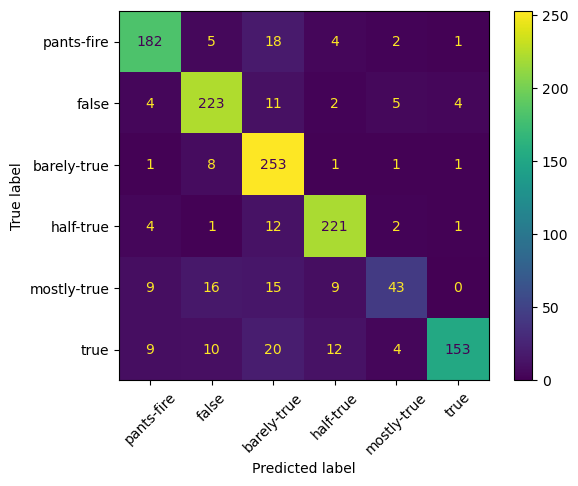

In [247]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# Define the labels
my_labels = ['pants-fire', 'false', 'barely-true', 'half-true', 'mostly-true', 'true']

# Calculate accuracy
accuracy = accuracy_score(test_data['label'], predicted_labels)
print('Accuracy:', accuracy)

# Generate the confusion matrix
cm = confusion_matrix(test_data['label'], predicted_labels, labels=my_labels)

# Display the confusion matrix
ConfusionMatrixDisplay.from_predictions(
    y_true=test_data['label'], 
    y_pred=predicted_labels, 
    display_labels=my_labels, 
    xticks_rotation=45
)

# Print additional information about the confusion matrix
print('(row=expected, col=predicted)')


In [248]:
test_data

label                                          statement  \
statement_id                                                                   
0                    true  Building a wall on the U.S.-Mexico border will...   
1                   false  Wisconsin is on pace to double the number of l...   
2                   false  Says John McCain has done nothing to help the ...   
3               half-true  Suzanne Bonamici supports a plan that will cut...   
4              pants-fire  When asked by a reporter whether hes at the ce...   
...                   ...                                                ...   
1262            half-true  Says his budget provides the highest state fun...   
1263          barely-true                    Ive been here almost every day.   
1264          barely-true  In the early 1980s, Sen. Edward Kennedy secret...   
1265          barely-true  Says an EPA permit languished under Strickland...   
1266                false  Says the governor is going around the state ta...   

                                                        subject  \
statement_id                                                      
0                                                   immigration   
1                                                          jobs   
2                               military,veterans,voting-record   
3             medicare,message-machine-2012,campaign-adverti...   
4             campaign-finance,legal-issues,campaign-adverti...   
...                                                         ...   
1262                                                  education   
1263                        civil-rights,crime,criminal-justice   
1264             bipartisanship,congress,foreign-policy,history   
1265                          environment,government-efficiency   
1266                          state-budget,state-finances,taxes   

                                       speaker  \
statement_id                                     
0                                   rick-perry   
1                            katrina-shankland   
2                                 donald-trump   
3                                rob-cornilles   
4             state-democratic-party-wisconsin   
...                                        ...   
1262                                rick-scott   
1263                                 jay-nixon   
1264                     mackubin-thomas-owens   
1265                               john-kasich   
1266                          john-burzichelli   

                                                     job_title         state  \
statement_id                                                                   
0                                                     Governor         Texas   
1                                         State representative     Wisconsin   
2                                              President-Elect      New York   
3                                                   consultant        Oregon   
4                                                          NaN     Wisconsin   
...                                                        ...           ...   
1262                                                  Governor       Florida   
1263                                                  Governor      Missouri   
1264          senior fellow, Foreign Policy Research Institute  Rhode Island   
1265                      Governor of Ohio as of Jan. 10, 2011          Ohio   
1266                                                       NaN           NaN   

                   party  barely_true_c  false_c  half_true_c  ...  \
statement_id                                                   ...   
0             republican             30       30           42  ...   
1               democrat              2        1            0  ...   
2             republican             63      114           51  ...   
3             republican              1        1            3  ..

## Error Analysis

In [249]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report

# y_true: Actual labels from the test data
y_true = test_data['label']

# y_pred: Predicted labels from the model
y_pred = predicted_labels

# Define your class labels
class_labels = ['pants-fire', 'false', 'barely-true', 'half-true', 'mostly-true', 'true']

# Calculate and print metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro', labels=class_labels)
recall = recall_score(y_true, y_pred, average='macro', labels=class_labels)
f1 = f1_score(y_true, y_pred, average='macro', labels=class_labels)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Alternatively, get a full classification report for each class
report = classification_report(y_true, y_pred, target_names=class_labels)
print("\nClassification Report:\n", report)


Accuracy: 0.8485
Precision: 0.8477
Recall: 0.8048
F1-Score: 0.8164

Classification Report:
               precision    recall  f1-score   support

  pants-fire       0.87      0.86      0.86       212
       false       0.85      0.90      0.87       249
 barely-true       0.77      0.95      0.85       265
   half-true       0.89      0.92      0.90       241
 mostly-true       0.75      0.47      0.58        92
        true       0.96      0.74      0.83       208

    accuracy                           0.85      1267
   macro avg       0.85      0.80      0.82      1267
weighted avg       0.85      0.85      0.84      1267



c:\Users\sigal\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\sigal\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\sigal\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\sigal\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not 

# Feature imporatance analysis

In [250]:
X_train

barely_true_c  false_c  half_true_c  mostly_true_c  \
statement_id                                                       
0                       0.0      1.0          0.0            0.0   
1                       0.0      0.0          1.0            1.0   
2                      70.0     71.0        160.0          163.0   
3                       7.0     19.0          3.0            5.0   
4                      15.0      9.0         20.0           19.0   
...                     ...      ...          ...            ...   
10233                   0.0      1.0          1.0            1.0   
10234                   0.0      0.0          0.0            1.0   
10235                   4.0     11.0          5.0            3.0   
10236                   3.0      1.0          3.0            0.0   
10237                   0.0      1.0          1.0            0.0   

              pants_on_fire_c  subject_embedding_mean  \
statement_id                                            
0                         0.0               -0.001117   
1                         0.0               -0.001864   
2                         9.0               -0.001106   
3                        44.0               -0.000096   
4                         2.0               -0.000229   
...                       ...                     ...   
10233                     0.0               -0.002111   
10234                     0.0               -0.000313   
10235                     3.0               -0.003737   
10236                     0.0               -0.003464   
10237                     2.0               -0.003191   

              job_title_embedding_mean  party_encoded  context_embedding_mean  \
statement_id                                                                    
0                             0.000574             20                0.002756   
1                            -0.002054              6                0.001641   
2                            -0.000946              6                0.005409   
3                             0.000511             17                0.002794   
4                            -0.000062              6                0.001408   
...                                ...            ...                     ...   
10233                         0.000074             17                0.001933   
10234                         0.000177             20               -0.000061   
10235                        -0.000315             20                0.001843   
10236                        -0.000160              6                0.009001   
10237                        -0.002075             20                0.003501   

              length_statement_words  length_statement_letters  \
statement_id                                                     
0                                 11                        72   
1                                 24                       118   
2                                 19                        87   
3                                 12                        67   
4                                 10                        45   
...                              ...                       ...   
10233                             17                        74   
10234                             14                        65   
10235                             28                       149   
10236                             11                        52   
10237                             30                       152   

              avg_word_length_per_statement  credibility_score  tfidf  \
statement_id                                                            
0                                  6.545455          70.000000      1   
1                                  4.916667          92.500000      2   
2                                  4.578947          86.670190      2   
3                                  5.583333          67.628205      1   
4                                  4

In [251]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Extract the feature importances from the trained model
feature_importances = model.feature_importances_

# Get the feature names from the training dataset (X_train)
feature_names = X_train.columns

# Create a DataFrame to display feature names and their importance
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sort features by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the top 20 important features
display(feature_importance_df.head(20))


Feature  Importance
13                          tfidf    0.347837
12              credibility_score    0.172217
2                     half_true_c    0.078646
3                   mostly_true_c    0.077075
1                         false_c    0.069712
0                   barely_true_c    0.063760
4                 pants_on_fire_c    0.042883
8          context_embedding_mean    0.022591
10       length_statement_letters    0.021882
5          subject_embedding_mean    0.021649
11  avg_word_length_per_statement    0.021623
6        job_title_embedding_mean    0.021086
9          length_statement_words    0.016642
14                 dominant_topic    0.013070
7                   party_encoded    0.009329

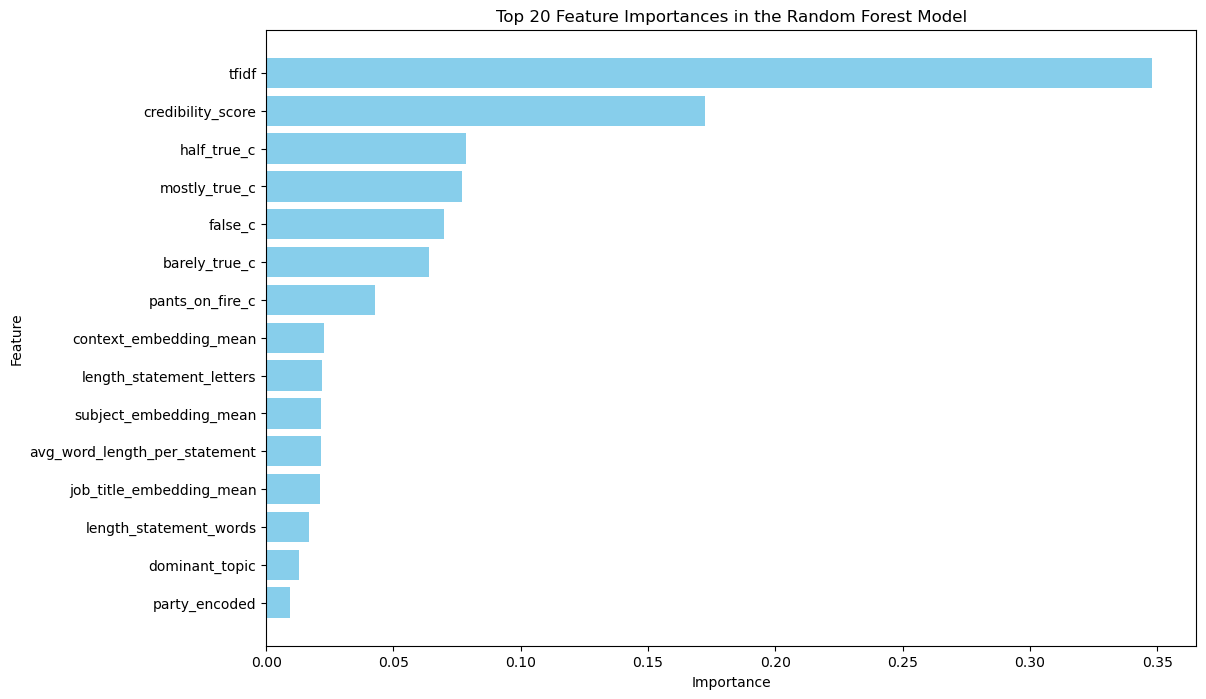

In [252]:
# Plot the top N most important features
plt.figure(figsize=(12, 8))
plt.barh(feature_importance_df['Feature'][:200], feature_importance_df['Importance'][:20], color='skyblue')
plt.gca().invert_yaxis()  # Invert y-axis to display the highest importance at the top
plt.title('Top 20 Feature Importances in the Random Forest Model')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


c:\Users\sigal\anaconda3\Lib\site-packages\sklearn\utils\validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\sigal\anaconda3\Lib\site-packages\sklearn\utils\validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


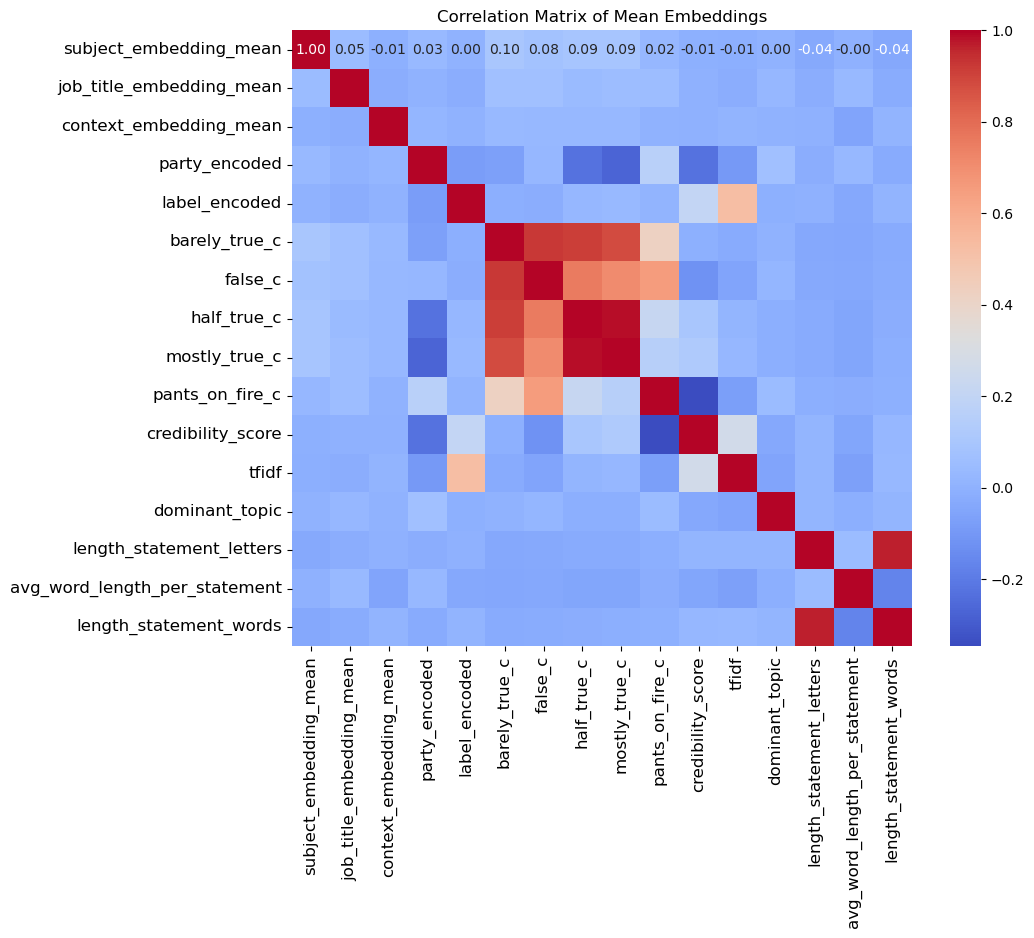

In [253]:
from numpy import dot
from numpy.linalg import norm
from scipy.stats import pearsonr

from sklearn.preprocessing import LabelEncoder

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

df = train_data.copy() # Use the train dataset for this analysis

# Fit and transform the 'label' column
df['label_encoded'] = label_encoder.fit_transform(df['label'])

# Apply cosine similarity between different embeddings
df['subject_embedding_mean'] = df['processed_subject_embedding'].apply(np.mean)
df['job_title_embedding_mean'] = df['processed_job_title_embedding'].apply(np.mean)
df['context_embedding_mean'] = df['processed_context_embedding'].apply(np.mean)

# Select relevant columns for correlation
'subject_embedding_mean', 'job_title_embedding_mean', 'context_embedding_mean','party_encoded','label_encoded', 
part_df = df[['subject_embedding_mean', 'job_title_embedding_mean', 'context_embedding_mean','party_encoded','label_encoded','barely_true_c', 'false_c', 'half_true_c', 'mostly_true_c', 'pants_on_fire_c', 'credibility_score', 'tfidf', 'dominant_topic', 'length_statement_letters','avg_word_length_per_statement','length_statement_words']]
correlation_matrix = part_df.corr()

# Display the correlation matrix as a plot
plt.figure(figsize=(10, 8))
plt.title('Correlation Matrix of Mean Embeddings')
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.xticks(size = 12)
plt.yticks(size = 12)
plt.show()


In [90]:
#print the correlation matrix

correlation_matrix

subject_embedding_mean  job_title_embedding_mean  \
subject_embedding_mean                  1.000000                  0.015553   
job_title_embedding_mean                0.015553                  1.000000   
context_embedding_mean                  0.025294                 -0.020417   
party_encoded                           0.026437                  0.009742   
label_encoded                          -0.011584                 -0.013590   
credibility_score                      -0.031683                  0.011909   
tfidf                                  -0.038207                 -0.016909   
dominant_topic                          0.033967                  0.025003   

                          context_embedding_mean  party_encoded  \
subject_embedding_mean                  0.025294       0.026437   
job_title_embedding_mean               -0.020417       0.009742   
context_embedding_mean                  1.000000       0.018301   
party_encoded                           0.018301       1.000000   
label_encoded                           0.007487      -0.082139   
credibility_score                      -0.014399      -0.230455   
tfidf                                   0.010696      -0.095477   
dominant_topic                         -0.001862       0.041606   

                          label_encoded  credibility_score     tfidf  \
subject_embedding_mean        -0.011584          -0.031683 -0.038207   
job_title_embedding_mean      -0.013590           0.011909 -0.016909   
context_embedding_mean         0.007487          -0.014399  0.010696   
party_encoded                 -0.082139          -0.230455 -0.095477   
label_encoded                  1.000000           0.204685  0.524010   
credibility_score              0.204685           1.000000  0.267456   
tfidf                          0.524010           0.267456  1.000000   
dominant_topic                -0.046554          -0.064857 -0.106418   

                          dominant_topic  
subject_embedding_mean          0.033967  
job_title_embedding_mean        0.025003  
context_embedding_mean         -0.001862  
party_encoded                   0.041606  
label_encoded                  -0.046554  
credibility_score              -0.064857  
tfidf                          -0.106418  
dominant_topic                  1.000000